# Vehicle Detection

*Much code adapted from Udacity's Vehicle Detection and Tracking Lesson*

This ipynb is designed for quick testing of different combinations of parameters of the classifier.

### 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier (e.g. a Linear SVM classifier)


#### 1.1 Set up helper functions for extracting HOG and colour features

#### 1.2 Prepare data for classifier (extract features)

In [1]:
import numpy as np
import cv2
import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

## 0. Default parameters
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 5  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()
image_file_name = "hogviz/rgb_ss1616_hb_16_TTT/" + "o" + str(orient) \
                    + "_ppc" + str(pix_per_cell) + "_cpb" \
                    + str(cell_per_block) + "_hc" + str(hog_channel)
image_title = str(pix_per_cell) + "ppc"
logfilepath = "logs/hogviz_experiments/ppc_exp1.md"

image = mpimg.imread('test_images/test1.jpg')
heatmap_template = np.zeros_like(image[:, :, 0]).astype(np.float)

## 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and
# train a classifier (e.g. a Linear SVM classifier)¶

## Helper functions for extracting HOG and colour features

# Adapted from Udacity L22 lesson_functions.py

def normalise(image):
    return (image - image.mean()) / (image.max() - image.min())

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=True, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features


# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True,
                     viz=False, viz_only=False, hog_viz_name="", viz_title="HOG Viz"):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if viz == True:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature, hog_image = get_hog_features(feature_image[:, :, channel],
                                                                  orient, pix_per_cell, cell_per_block,
                                                                  vis=True, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features, hog_image = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                               pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                # Plot HOG visualisation

                if viz_only == True:
                    fig = plt.figure()
                    plt.imshow(hog_image)
                    plt.title(viz_title)
                    plt.savefig(hog_viz_name, bbox_inches='tight')

                else:
                    fig = plt.figure()
                    plt.subplot(121)
                    plt.imshow(image)
                    plt.title('Example Image')
                    plt.subplot(122)
                    plt.imshow(hog_image)
                    plt.title('Example HOG viz')
                    plt.savefig(hog_viz_name + "_double", bbox_inches='tight')

            else:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature = get_hog_features(feature_image[:, :, channel],
                                                       orient, pix_per_cell, cell_per_block,
                                                       vis=False, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## 2. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5), polygon_mask=None):
    """Returns all windows to search in an image.
    No classification has been done at this stage.
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1

    # Initialize a list to append window positions to
    window_list = []

    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            if polygon_mask is not None:
                if polygon_mask[int(starty)][int(startx)] > 0:
                    # Append window position to list
                    window_list.append(((startx, starty), (endx, endy)))
            else:
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    """Returns a list of windows the classifier has predicted contain cars."""
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        # print("features: ", features)

        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # print("Test features: ", test_features)
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows


## 4. Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to
## reject outliers and follow detected vehicles.



def add_heat(heatmap, box_list):
    """Returns `heatmap` with bounding boxes in `box_list` added to it.
    `box_list` is an array of boxes.

    This function should be applied per frame.
    """
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    """Returns heatmap with false positives removed."""
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def create_heatmaps(all_bboxes, recent_frames_used=20, threshold=5):
    """
    Produces a heatmap for each frame in `all_bboxes` and returns
    an array of heatmaps.

    `all_bboxes` is an array of arrays of bboxes.
    Each element represents a frame. Each element is an array of bboxes found in
    that frame."""
    heatmap_list = []

    for idx, boxlist in enumerate(all_bboxes):
        # Produce heatmap for the most recent e.g. 10 frames:
        # print("Boxlist: ", boxlist)
        idx_start = max(idx - recent_frames_used, 0)
        idx_heatmap = heatmap_template
        for boxlist2 in all_bboxes[idx_start:idx + 1]:
            idx_heatmap = add_heat(idx_heatmap, boxlist2)
            # print("Boxlist2: ", boxlist2)

        # Apply threshold
        idx_heatmap = apply_threshold(idx_heatmap, threshold)

        # Add heatmap to list of heatmaps
        heatmap_list.append(idx_heatmap)
        plt.imshow(idx_heatmap, cmap="hot")

        # Don't know what this is for:
        # final_map = np.clip(heat - 2, 0, 255)
    return heatmap_list

## 5. Estimate a bounding box for vehicles detected.

# Combine multiple detections

def draw_labeled_bboxes(img, labels):
    """Return image with bounding boxes drawn around the labelled regions.
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img





In [2]:
import numpy as np
import cv2
import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, 
                        viz=False, viz_only=False, hog_viz_name="", viz_title="HOG Viz"):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if viz == True:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature, hog_image = get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=True, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                # Plot HOG visualisation
                
                if viz_only == True:
                    fig = plt.figure()
                    plt.imshow(hog_image)
                    plt.title(viz_title)
                    plt.savefig(hog_viz_name, bbox_inches='tight')
                    
                else:
                    fig = plt.figure()
                    plt.subplot(121)
                    plt.imshow(image)
                    plt.title('Example Image')
                    plt.subplot(122)
                    plt.imshow(hog_image)
                    plt.title('Example HOG viz')
                    plt.savefig(hog_viz_name + "_double", bbox_inches='tight')
                
            else:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature = get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
            

### Sliding window helper functions


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

/home/saksham/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Using: 7 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2188
0.1277 Seconds to train SVC...
Test Accuracy of SVC =  0.955


/home/saksham/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/home/saksham/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/home/saksham/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/home/saksham/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/home/saksham/.local/lib/python3.6/site-pack

/home/saksham/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/home/saksham/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/home/saksham/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/home/saksham/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/home/saksham/.local/lib/python3.6/site-pack

/home/saksham/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/home/saksham/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/home/saksham/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/home/saksham/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/home/saksham/.local/lib/python3.6/site-pack

FileNotFoundError: [Errno 2] No such file or directory: 'hogviz/rgb_ss1616_hb_16_TTT/o7_ppc50_cpb2_hc0_window.png'

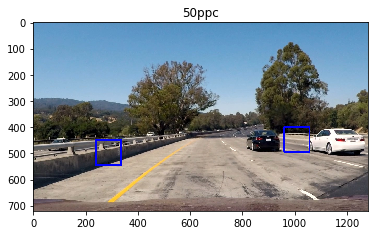

In [3]:
from sys import argv

import numpy as np
import cv2
import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from experiment_helper_functions import *

## 0 Parameters
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7  # HOG orientations
pix_per_cell = 50 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()
image_file_name = "hogviz/rgb_ss1616_hb_16_TTT/" + "o" + str(orient) \
                    + "_ppc" + str(pix_per_cell) + "_cpb" \
                    + str(cell_per_block) + "_hc" + str(hog_channel)
image_title = str(pix_per_cell) + "ppc"
logfilepath = "logs/hogviz_experiments/ppc_exp1.md"

# Make it easier
pix_per_cell = 8


## 1.1 Set up helper functions (imported)

## 1.2 Prepare data for classifier (extract features)

# Read in cars and notcars
cars = glob.glob('vehicles/*/*/*.png')
notcars = glob.glob('non-vehicles/*/*/*.png')

# TODO: Remove
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

sample_car = [cars[42]]
sample_notcar = [notcars[42]]

# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


## 1.3 Train classifier

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
training_time = round(t2-t, 4)
print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

with open(logfilepath, "a") as f:
    f.write("\n\n" + str(image_file_name))
    f.write("\nParameters:")
    f.write("\ncolor_space: " + str(color_space))
    f.write("\norient: " + str(orient))
    f.write("\npix_per_cell: " + str(pix_per_cell))
    f.write("\ncell_per_block: " + str(cell_per_block))
    f.write("\nhog_channel: " + str(hog_channel))
    f.write("\nspatial_size: " + str(spatial_size))
    f.write("\nhist_bins: " + str(hist_bins))
    f.write("\nspatial_feat: " + str(spatial_feat))
    f.write("\nhist_feat: " + str(hist_feat))
    f.write("\nhog_feat: " + str(hog_feat))
    f.write('\nFeature vector length:' + str(len(X_train[0])))
    f.write("\n" + str(training_time) + 'Seconds to train SVC...')
    f.write('\nTest Accuracy of SVC = ' + str(svc_score))

## 2. Implement a sliding-window technique
    
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.title(image_title)
plt.imshow(window_img)
plt.savefig(image_file_name + "_window")

print(image_file_name, " complete.")

In [ ]:
# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

### Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

#### 1.3 Train classifier

In [4]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
training_time = round(t2-t, 4)
print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

# Log training parameters and results

with open(logfilepath, "a") as f:
    f.write("\n\n" + str(image_file_name))
    f.write("\nParameters:")
    f.write("\ncolor_space: " + str(color_space))
    f.write("\norient: " + str(orient))
    f.write("\npix_per_cell: " + str(pix_per_cell))
    f.write("\ncell_per_block: " + str(cell_per_block))
    f.write("\nhog_channel: " + str(hog_channel))
    f.write("\nspatial_size: " + str(spatial_size))
    f.write("\nhist_bins: " + str(hist_bins))
    f.write("\nspatial_feat: " + str(spatial_feat))
    f.write("\nhist_feat: " + str(hist_feat))
    f.write("\nhog_feat: " + str(hog_feat))
    f.write('\nFeature vector length:' + str(len(X_train[0])))
    f.write("\n" + str(training_time) + 'Seconds to train SVC...')
    f.write('\nTest Accuracy of SVC = ' + str(svc_score))

print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)

0.1548 Seconds to train SVC...
Test Accuracy of SVC =  0.975


FileNotFoundError: [Errno 2] No such file or directory: 'logs/hogviz_experiments/ppc_exp1.md'

### 2. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [29]:
def draw_on_image(testimage_number):
    # Read in image
    image = mpimg.imread('test_images/test' + str(testimage_number) + '.jpg')
    draw_image = np.copy(image)

    # Rescale data since training data extracted from 
    # .png images (scaled 0 to 1 by mpimg) and image we
    # are searching is .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    # Get list of windows to search at this stage.
    windows = slide_window(image, x_start_stop=[600, 1280], y_start_stop=y_start_stop, 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size)

    # Return all the windows the classifier has predicted contain car(s) ('positive windows').
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    # Draw bounding boxes around the windows that the classifier predicted has cars in them
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    # Plot image with bounding boxes drawn.
    plt.title(image_title)
    plt.imshow(window_img)
    plt.savefig(image_file_name + "_window_test" + str(testimage_number) + ".png")

In [30]:
print("y bounds for region we search using the sliding window technique: ", 
      y_start_stop)

y bounds for region we search using the sliding window technique:  [400, 720]


In [31]:
draw_on_image(1)

NameError: name 'xy_window_size' is not defined

In [32]:
draw_on_image(2)

NameError: name 'xy_window_size' is not defined

In [33]:
draw_on_image(3)

NameError: name 'xy_window_size' is not defined

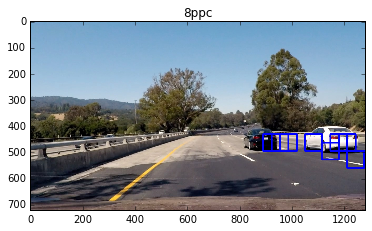

In [457]:
draw_on_image(4)

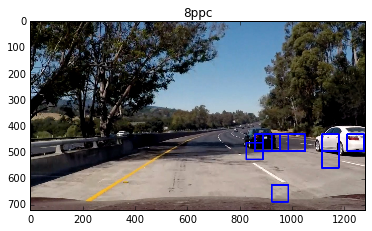

In [458]:
draw_on_image(5)

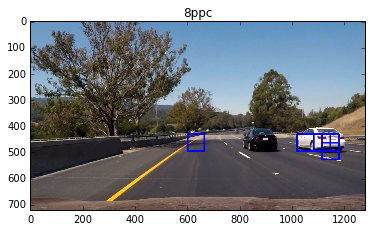

In [459]:
draw_on_image(6)

In [460]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 3 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
xy_window_size = (64, 64)
xy_overlap_size = (0.5, 0.5)

y_start_stop = [400, 720] # Min and max in y to search in slide_window()
image_file_name = "hogviz/" + str(color_space) + "_ss" + str(spatial_size[0]) + str(spatial_size[1]) + "_hb" + str(hist_bins) + "_TTT_" + "o" + str(orient) \
                    + "_ppc" + str(pix_per_cell) + "_cpb" \
                    + str(cell_per_block) + "_hc" + str(hog_channel) + "_wdw" \
                    #+ str(xy_window_size[0]) + str(xy_window_size[1]) + "_olp" \
                    #+ str(xy_overlap_size[0]) + str(xy_overlap_size[1])
image_title = str(pix_per_cell) + "ppc"
logfilepath = "logs/hogviz_experiments/ppc_exp1.md"

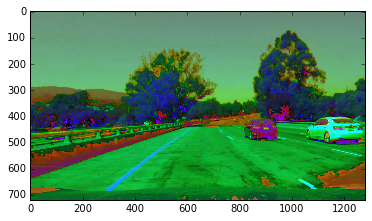

In [461]:
# Can be RGB, HSV, LUV, HLS, YUV, YCrCb

plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2HLS))

### 4. Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

In [462]:
def add_bboxes(input_image, windows, classifier, scaler, draw=True, bboxes_only=False):
    """Adds bounding boxes from `input_image` (one array of arrays) to
    the global variable `bboxes_list`'.
    If `draw` is True, returns image overlaid with bounding boxes.
    """
    global bboxes_list
    hot_windows = search_windows(input_image, windows, classifier, scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
    print("Hot windows: ", hot_windows)
    bboxes_list.append(hot_windows)
    if draw == True:
        draw_image = np.copy(input_image)
        window_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img

In [463]:
def add_bboxes_to_list(image):
    """Adds bounding boxes in `image` to global `bboxes_list`.
    Returns image with bounding boxes drawn.
    """
    return add_bboxes(image, windows, svc, X_scaler)

[MoviePy reference](https://zulko.github.io/moviepy/crash_course/crash_course.html)

#### Combine multiple detections and remove false positives

In [464]:
# Read in the last image shown above 
image = mpimg.imread('test_images/test1.jpg')

# Create heatmap template
heatmap_template = np.zeros_like(image[:,:,0]).astype(np.float)

In [465]:
def add_heat(heatmap, box_list):
    """Returns `heatmap` with bounding boxes in `bbox_list` added to it.
    `bbox_list` is an array of boxes.

    This function should be applied per frame.
    """
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

### 5. Estimate a bounding box for vehicles detected.

In [466]:
# Implement using a queue of length `recent_frames_used`.
# MVP can just go through the array each time cause I'm lazy

def draw_filtered_bboxes(image, all_bboxes, recent_frames_used=20, threshold=5): 
    """`all_bboxes` is an array of arrays of bboxes.
    Each element represents a frame. Each element is an array of bboxes found in
    that frame."""
    
    # Add bounding boxes from this frame
    add_bboxes(image, windows, svc, X_scaler, draw=False)
    
    if len(all_bboxes) < recent_frames_used + 1:
        recent_frames_used = len(all_bboxes) - 1
    
    frame_heatmap = np.zeros_like(image[:,:,0])
    
    for boxlist in all_bboxes[-recent_frames_used:]:
        frame_heatmap = add_heat(frame_heatmap, boxlist)
    
    # Apply threshold
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    
    labels = label(frame_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.imshow(draw_img)
    return draw_img

In [467]:
def process_image(image):
    global bboxes_list    
    
    return draw_filtered_bboxes(image, bboxes_list)

Hot windows:  []
[MoviePy] >>>> Building video output_v1.mp4
[MoviePy] Writing video output_v1.mp4


  0%|          | 1/1261 [00:00<12:35,  1.67it/s]

Hot windows:  []


  0%|          | 2/1261 [00:01<12:19,  1.70it/s]

Hot windows:  []


  0%|          | 3/1261 [00:01<12:13,  1.71it/s]

Hot windows:  []


  0%|          | 4/1261 [00:02<12:06,  1.73it/s]

Hot windows:  []


  0%|          | 5/1261 [00:02<11:59,  1.74it/s]

Hot windows:  []


  0%|          | 6/1261 [00:03<12:00,  1.74it/s]

Hot windows:  []


  1%|          | 7/1261 [00:03<11:44,  1.78it/s]

Hot windows:  []


  1%|          | 8/1261 [00:04<11:50,  1.76it/s]

Hot windows:  []


  1%|          | 9/1261 [00:05<11:50,  1.76it/s]

Hot windows:  []


  1%|          | 10/1261 [00:05<11:40,  1.79it/s]

Hot windows:  []


  1%|          | 11/1261 [00:06<11:37,  1.79it/s]

Hot windows:  []


  1%|          | 12/1261 [00:06<11:40,  1.78it/s]

Hot windows:  [((1112, 464), (1176, 528))]


  1%|          | 13/1261 [00:07<11:30,  1.81it/s]

Hot windows:  []


  1%|          | 14/1261 [00:07<11:24,  1.82it/s]

Hot windows:  [((1112, 464), (1176, 528))]


  1%|          | 15/1261 [00:08<11:20,  1.83it/s]

Hot windows:  []


  1%|▏         | 16/1261 [00:08<11:15,  1.84it/s]

Hot windows:  []


  1%|▏         | 17/1261 [00:09<11:14,  1.84it/s]

Hot windows:  []


  1%|▏         | 18/1261 [00:10<11:11,  1.85it/s]

Hot windows:  []


  2%|▏         | 19/1261 [00:10<11:11,  1.85it/s]

Hot windows:  []


  2%|▏         | 20/1261 [00:11<11:09,  1.85it/s]

Hot windows:  []


  2%|▏         | 21/1261 [00:11<11:09,  1.85it/s]

Hot windows:  [((952, 400), (1016, 464))]


  2%|▏         | 22/1261 [00:12<11:10,  1.85it/s]

Hot windows:  []


  2%|▏         | 23/1261 [00:12<11:33,  1.78it/s]

Hot windows:  []


  2%|▏         | 24/1261 [00:13<11:59,  1.72it/s]

Hot windows:  []


  2%|▏         | 25/1261 [00:13<12:01,  1.71it/s]

Hot windows:  [((984, 400), (1048, 464))]


  2%|▏         | 26/1261 [00:14<12:05,  1.70it/s]

Hot windows:  []


  2%|▏         | 27/1261 [00:15<12:21,  1.66it/s]

Hot windows:  [((1080, 464), (1144, 528))]


  2%|▏         | 28/1261 [00:15<12:53,  1.59it/s]

Hot windows:  []


  2%|▏         | 29/1261 [00:16<12:49,  1.60it/s]

Hot windows:  [((1016, 400), (1080, 464))]


  2%|▏         | 30/1261 [00:17<12:54,  1.59it/s]

Hot windows:  [((984, 400), (1048, 464))]


  2%|▏         | 31/1261 [00:17<12:52,  1.59it/s]

Hot windows:  []


  3%|▎         | 32/1261 [00:18<12:57,  1.58it/s]

Hot windows:  []


  3%|▎         | 33/1261 [00:19<13:01,  1.57it/s]

Hot windows:  []


  3%|▎         | 34/1261 [00:19<12:45,  1.60it/s]

Hot windows:  []


  3%|▎         | 35/1261 [00:20<12:31,  1.63it/s]

Hot windows:  []


  3%|▎         | 36/1261 [00:20<12:32,  1.63it/s]

Hot windows:  []


  3%|▎         | 37/1261 [00:21<12:38,  1.61it/s]

Hot windows:  []


  3%|▎         | 38/1261 [00:22<12:24,  1.64it/s]

Hot windows:  []


  3%|▎         | 39/1261 [00:22<12:13,  1.67it/s]

Hot windows:  [((1080, 400), (1144, 464))]


  3%|▎         | 40/1261 [00:23<12:05,  1.68it/s]

Hot windows:  []


  3%|▎         | 41/1261 [00:23<12:15,  1.66it/s]

Hot windows:  []


  3%|▎         | 42/1261 [00:24<11:59,  1.69it/s]

Hot windows:  []


  3%|▎         | 43/1261 [00:25<11:59,  1.69it/s]

Hot windows:  []


  3%|▎         | 44/1261 [00:25<12:02,  1.68it/s]

Hot windows:  []


  4%|▎         | 45/1261 [00:26<12:20,  1.64it/s]

Hot windows:  []


  4%|▎         | 46/1261 [00:26<12:26,  1.63it/s]

Hot windows:  []


  4%|▎         | 47/1261 [00:27<12:24,  1.63it/s]

Hot windows:  []


  4%|▍         | 48/1261 [00:28<12:07,  1.67it/s]

Hot windows:  []


  4%|▍         | 49/1261 [00:28<12:10,  1.66it/s]

Hot windows:  []


  4%|▍         | 50/1261 [00:29<11:58,  1.69it/s]

Hot windows:  []


  4%|▍         | 51/1261 [00:29<12:00,  1.68it/s]

Hot windows:  []


  4%|▍         | 52/1261 [00:30<11:46,  1.71it/s]

Hot windows:  []


  4%|▍         | 53/1261 [00:31<11:44,  1.71it/s]

Hot windows:  []


  4%|▍         | 54/1261 [00:31<11:38,  1.73it/s]

Hot windows:  []


  4%|▍         | 55/1261 [00:32<11:33,  1.74it/s]

Hot windows:  []


  4%|▍         | 56/1261 [00:32<11:41,  1.72it/s]

Hot windows:  []


  5%|▍         | 57/1261 [00:33<11:36,  1.73it/s]

Hot windows:  []


  5%|▍         | 58/1261 [00:33<11:30,  1.74it/s]

Hot windows:  [((1080, 432), (1144, 496))]


  5%|▍         | 59/1261 [00:34<11:19,  1.77it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


  5%|▍         | 60/1261 [00:34<11:15,  1.78it/s]

Hot windows:  []


  5%|▍         | 61/1261 [00:35<11:09,  1.79it/s]

Hot windows:  []


  5%|▍         | 62/1261 [00:36<11:06,  1.80it/s]

Hot windows:  []


  5%|▍         | 63/1261 [00:36<10:59,  1.82it/s]

Hot windows:  []


  5%|▌         | 64/1261 [00:37<10:58,  1.82it/s]

Hot windows:  []


  5%|▌         | 65/1261 [00:37<10:55,  1.82it/s]

Hot windows:  []


  5%|▌         | 66/1261 [00:38<10:54,  1.83it/s]

Hot windows:  []


  5%|▌         | 67/1261 [00:38<10:51,  1.83it/s]

Hot windows:  []


  5%|▌         | 68/1261 [00:39<10:52,  1.83it/s]

Hot windows:  []


  5%|▌         | 69/1261 [00:39<10:50,  1.83it/s]

Hot windows:  []


  6%|▌         | 70/1261 [00:40<10:48,  1.84it/s]

Hot windows:  []


  6%|▌         | 71/1261 [00:40<10:48,  1.83it/s]

Hot windows:  []


  6%|▌         | 72/1261 [00:41<10:46,  1.84it/s]

Hot windows:  []


  6%|▌         | 73/1261 [00:42<10:47,  1.83it/s]

Hot windows:  []


  6%|▌         | 74/1261 [00:42<10:47,  1.83it/s]

Hot windows:  []


  6%|▌         | 75/1261 [00:43<10:47,  1.83it/s]

Hot windows:  []


  6%|▌         | 76/1261 [00:43<10:41,  1.85it/s]

Hot windows:  []


  6%|▌         | 77/1261 [00:44<10:42,  1.84it/s]

Hot windows:  [((1048, 656), (1112, 720))]


  6%|▌         | 78/1261 [00:44<10:40,  1.85it/s]

Hot windows:  [((1048, 656), (1112, 720))]


  6%|▋         | 79/1261 [00:45<10:40,  1.85it/s]

Hot windows:  [((1048, 656), (1112, 720))]


  6%|▋         | 80/1261 [00:45<10:44,  1.83it/s]

Hot windows:  []


  6%|▋         | 81/1261 [00:46<10:42,  1.84it/s]

Hot windows:  [((1080, 656), (1144, 720))]


  7%|▋         | 82/1261 [00:46<10:40,  1.84it/s]

Hot windows:  [((1080, 656), (1144, 720))]


  7%|▋         | 83/1261 [00:47<10:36,  1.85it/s]

Hot windows:  [((1080, 656), (1144, 720))]


  7%|▋         | 84/1261 [00:48<10:37,  1.85it/s]

Hot windows:  []


  7%|▋         | 85/1261 [00:48<10:35,  1.85it/s]

Hot windows:  []


  7%|▋         | 86/1261 [00:49<10:35,  1.85it/s]

Hot windows:  []


  7%|▋         | 87/1261 [00:49<10:33,  1.85it/s]

Hot windows:  []


  7%|▋         | 88/1261 [00:50<10:33,  1.85it/s]

Hot windows:  []


  7%|▋         | 89/1261 [00:50<10:30,  1.86it/s]

Hot windows:  []


  7%|▋         | 90/1261 [00:51<10:35,  1.84it/s]

Hot windows:  []


  7%|▋         | 91/1261 [00:51<10:33,  1.85it/s]

Hot windows:  []


  7%|▋         | 92/1261 [00:52<10:36,  1.84it/s]

Hot windows:  []


  7%|▋         | 93/1261 [00:52<10:36,  1.83it/s]

Hot windows:  []


  7%|▋         | 94/1261 [00:53<10:31,  1.85it/s]

Hot windows:  []


  8%|▊         | 95/1261 [00:53<10:28,  1.85it/s]

Hot windows:  [((984, 400), (1048, 464))]


  8%|▊         | 96/1261 [00:54<10:26,  1.86it/s]

Hot windows:  [((984, 400), (1048, 464))]


  8%|▊         | 97/1261 [00:55<10:28,  1.85it/s]

Hot windows:  []


  8%|▊         | 98/1261 [00:55<10:24,  1.86it/s]

Hot windows:  [((952, 400), (1016, 464)), ((920, 432), (984, 496))]


  8%|▊         | 99/1261 [00:56<10:24,  1.86it/s]

Hot windows:  [((1144, 432), (1208, 496))]


  8%|▊         | 100/1261 [00:56<10:22,  1.86it/s]

Hot windows:  []


  8%|▊         | 101/1261 [00:57<10:24,  1.86it/s]

Hot windows:  []


  8%|▊         | 102/1261 [00:57<10:21,  1.87it/s]

Hot windows:  []


  8%|▊         | 103/1261 [00:58<10:20,  1.87it/s]

Hot windows:  [((984, 400), (1048, 464))]


  8%|▊         | 104/1261 [00:58<10:20,  1.87it/s]

Hot windows:  [((1016, 400), (1080, 464))]


  8%|▊         | 105/1261 [00:59<10:20,  1.86it/s]

Hot windows:  []


  8%|▊         | 106/1261 [00:59<10:19,  1.86it/s]

Hot windows:  []


  8%|▊         | 107/1261 [01:00<10:16,  1.87it/s]

Hot windows:  [((1016, 400), (1080, 464)), ((1048, 400), (1112, 464))]


  9%|▊         | 108/1261 [01:00<10:16,  1.87it/s]

Hot windows:  [((1016, 400), (1080, 464)), ((1048, 400), (1112, 464))]


  9%|▊         | 109/1261 [01:01<10:16,  1.87it/s]

Hot windows:  []


  9%|▊         | 110/1261 [01:02<10:16,  1.87it/s]

Hot windows:  [((920, 432), (984, 496))]


  9%|▉         | 111/1261 [01:02<10:14,  1.87it/s]

Hot windows:  [((1048, 400), (1112, 464))]


  9%|▉         | 112/1261 [01:03<10:14,  1.87it/s]

Hot windows:  [((1048, 400), (1112, 464))]


  9%|▉         | 113/1261 [01:03<10:14,  1.87it/s]

Hot windows:  []


  9%|▉         | 114/1261 [01:04<10:15,  1.86it/s]

Hot windows:  []


  9%|▉         | 115/1261 [01:04<10:12,  1.87it/s]

Hot windows:  []


  9%|▉         | 116/1261 [01:05<10:13,  1.87it/s]

Hot windows:  [((1208, 464), (1272, 528))]


  9%|▉         | 117/1261 [01:05<10:11,  1.87it/s]

Hot windows:  []


  9%|▉         | 118/1261 [01:06<10:12,  1.87it/s]

Hot windows:  [((1208, 464), (1272, 528))]


  9%|▉         | 119/1261 [01:06<10:12,  1.87it/s]

Hot windows:  []


 10%|▉         | 120/1261 [01:07<10:09,  1.87it/s]

Hot windows:  []


 10%|▉         | 121/1261 [01:07<10:10,  1.87it/s]

Hot windows:  []


 10%|▉         | 122/1261 [01:08<10:12,  1.86it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 10%|▉         | 123/1261 [01:08<10:15,  1.85it/s]

Hot windows:  []


 10%|▉         | 124/1261 [01:09<10:11,  1.86it/s]

Hot windows:  []


 10%|▉         | 125/1261 [01:10<10:10,  1.86it/s]

Hot windows:  []


 10%|▉         | 126/1261 [01:10<10:06,  1.87it/s]

Hot windows:  [((1176, 464), (1240, 528))]


 10%|█         | 127/1261 [01:11<10:04,  1.88it/s]

Hot windows:  []


 10%|█         | 128/1261 [01:11<10:00,  1.89it/s]

Hot windows:  []


 10%|█         | 129/1261 [01:12<10:00,  1.89it/s]

Hot windows:  []


 10%|█         | 130/1261 [01:12<09:57,  1.89it/s]

Hot windows:  [((1080, 464), (1144, 528))]


 10%|█         | 131/1261 [01:13<09:59,  1.88it/s]

Hot windows:  []


 10%|█         | 132/1261 [01:13<09:58,  1.89it/s]

Hot windows:  []


 11%|█         | 133/1261 [01:14<09:57,  1.89it/s]

Hot windows:  []


 11%|█         | 134/1261 [01:14<09:56,  1.89it/s]

Hot windows:  []


 11%|█         | 135/1261 [01:15<09:59,  1.88it/s]

Hot windows:  []


 11%|█         | 136/1261 [01:15<10:00,  1.87it/s]

Hot windows:  []


 11%|█         | 137/1261 [01:16<09:56,  1.88it/s]

Hot windows:  []


 11%|█         | 138/1261 [01:16<09:57,  1.88it/s]

Hot windows:  []


 11%|█         | 139/1261 [01:17<09:53,  1.89it/s]

Hot windows:  []


 11%|█         | 140/1261 [01:18<09:55,  1.88it/s]

Hot windows:  [((1208, 464), (1272, 528))]


 11%|█         | 141/1261 [01:18<09:53,  1.89it/s]

Hot windows:  [((1208, 464), (1272, 528))]


 11%|█▏        | 142/1261 [01:19<09:54,  1.88it/s]

Hot windows:  [((1208, 464), (1272, 528))]


 11%|█▏        | 143/1261 [01:19<09:53,  1.88it/s]

Hot windows:  [((1208, 496), (1272, 560))]


 11%|█▏        | 144/1261 [01:20<09:55,  1.88it/s]

Hot windows:  [((1208, 496), (1272, 560))]


 11%|█▏        | 145/1261 [01:20<09:53,  1.88it/s]

Hot windows:  [((1208, 432), (1272, 496)), ((1208, 464), (1272, 528)), ((1208, 496), (1272, 560))]


 12%|█▏        | 146/1261 [01:21<09:58,  1.86it/s]

Hot windows:  [((1208, 432), (1272, 496)), ((1208, 464), (1272, 528))]


 12%|█▏        | 147/1261 [01:21<09:55,  1.87it/s]

Hot windows:  [((888, 432), (952, 496)), ((1208, 432), (1272, 496)), ((1208, 464), (1272, 528))]


 12%|█▏        | 148/1261 [01:22<09:55,  1.87it/s]

Hot windows:  [((1208, 432), (1272, 496))]


 12%|█▏        | 149/1261 [01:22<09:54,  1.87it/s]

Hot windows:  [((920, 432), (984, 496)), ((1208, 432), (1272, 496))]


 12%|█▏        | 150/1261 [01:23<09:54,  1.87it/s]

Hot windows:  [((1208, 432), (1272, 496))]


 12%|█▏        | 151/1261 [01:23<09:55,  1.87it/s]

Hot windows:  [((1208, 432), (1272, 496))]


 12%|█▏        | 152/1261 [01:24<09:51,  1.88it/s]

Hot windows:  [((1208, 432), (1272, 496)), ((1176, 464), (1240, 528))]


 12%|█▏        | 153/1261 [01:24<09:49,  1.88it/s]

Hot windows:  [((1208, 432), (1272, 496)), ((1176, 464), (1240, 528))]


 12%|█▏        | 154/1261 [01:25<09:47,  1.88it/s]

Hot windows:  []


 12%|█▏        | 155/1261 [01:26<09:46,  1.89it/s]

Hot windows:  [((1176, 464), (1240, 528))]


 12%|█▏        | 156/1261 [01:26<09:44,  1.89it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]


 12%|█▏        | 157/1261 [01:27<09:46,  1.88it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 13%|█▎        | 158/1261 [01:27<09:44,  1.89it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1208, 464), (1272, 528))]


 13%|█▎        | 159/1261 [01:28<09:45,  1.88it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 13%|█▎        | 160/1261 [01:28<09:44,  1.88it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 464), (1272, 528))]


 13%|█▎        | 161/1261 [01:29<09:44,  1.88it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 464), (1272, 528))]


 13%|█▎        | 162/1261 [01:29<09:42,  1.89it/s]

Hot windows:  [((920, 432), (984, 496)), ((1176, 432), (1240, 496))]


 13%|█▎        | 163/1261 [01:30<09:43,  1.88it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 13%|█▎        | 164/1261 [01:30<09:42,  1.88it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((1176, 432), (1240, 496)), ((1144, 464), (1208, 528))]


 13%|█▎        | 165/1261 [01:31<09:43,  1.88it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((1176, 432), (1240, 496)), ((1144, 464), (1208, 528))]


 13%|█▎        | 166/1261 [01:31<09:43,  1.88it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((1176, 432), (1240, 496)), ((1144, 464), (1208, 528))]


 13%|█▎        | 167/1261 [01:32<09:41,  1.88it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1144, 464), (1208, 528)), ((1176, 464), (1240, 528))]


 13%|█▎        | 168/1261 [01:32<09:43,  1.87it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]


 13%|█▎        | 169/1261 [01:33<09:41,  1.88it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]


 13%|█▎        | 170/1261 [01:33<09:42,  1.87it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]


 14%|█▎        | 171/1261 [01:34<09:41,  1.87it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]


 14%|█▎        | 172/1261 [01:35<09:41,  1.87it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 14%|█▎        | 173/1261 [01:35<09:38,  1.88it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 14%|█▍        | 174/1261 [01:36<09:40,  1.87it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 14%|█▍        | 175/1261 [01:36<09:39,  1.88it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 14%|█▍        | 176/1261 [01:37<09:40,  1.87it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1144, 432), (1208, 496))]


 14%|█▍        | 177/1261 [01:37<09:37,  1.88it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1144, 432), (1208, 496))]


 14%|█▍        | 178/1261 [01:38<09:37,  1.87it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]


 14%|█▍        | 179/1261 [01:38<09:36,  1.88it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1048, 464), (1112, 528)), ((1112, 464), (1176, 528))]


 14%|█▍        | 180/1261 [01:39<09:44,  1.85it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]


 14%|█▍        | 181/1261 [01:39<09:43,  1.85it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1112, 464), (1176, 528)), ((1144, 464), (1208, 528))]


 14%|█▍        | 182/1261 [01:40<09:39,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1144, 464), (1208, 528))]


 15%|█▍        | 183/1261 [01:40<09:37,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1144, 464), (1208, 528))]


 15%|█▍        | 184/1261 [01:41<09:34,  1.88it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1144, 464), (1208, 528))]


 15%|█▍        | 185/1261 [01:42<09:33,  1.88it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1144, 464), (1208, 528))]


 15%|█▍        | 186/1261 [01:42<09:32,  1.88it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 15%|█▍        | 187/1261 [01:43<09:32,  1.88it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1208, 464), (1272, 528))]


 15%|█▍        | 188/1261 [01:43<09:32,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 15%|█▍        | 189/1261 [01:44<09:32,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 15%|█▌        | 190/1261 [01:44<09:31,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 15%|█▌        | 191/1261 [01:45<09:33,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 15%|█▌        | 192/1261 [01:45<09:39,  1.84it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((1112, 432), (1176, 496))]


 15%|█▌        | 193/1261 [01:46<09:37,  1.85it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((1112, 432), (1176, 496))]


 15%|█▌        | 194/1261 [01:46<09:35,  1.85it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]


 15%|█▌        | 195/1261 [01:47<09:31,  1.86it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]


 16%|█▌        | 196/1261 [01:47<09:30,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]


 16%|█▌        | 197/1261 [01:48<09:28,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]


 16%|█▌        | 198/1261 [01:48<09:27,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]


 16%|█▌        | 199/1261 [01:49<09:25,  1.88it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]


 16%|█▌        | 200/1261 [01:50<09:25,  1.88it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]


 16%|█▌        | 201/1261 [01:50<09:23,  1.88it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]


 16%|█▌        | 202/1261 [01:51<09:24,  1.88it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1080, 464), (1144, 528)), ((1112, 464), (1176, 528))]


 16%|█▌        | 203/1261 [01:51<09:22,  1.88it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1080, 464), (1144, 528)), ((1112, 464), (1176, 528))]


 16%|█▌        | 204/1261 [01:52<09:23,  1.88it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1080, 464), (1144, 528)), ((1112, 464), (1176, 528))]


 16%|█▋        | 205/1261 [01:52<09:22,  1.88it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1112, 464), (1176, 528)), ((1176, 464), (1240, 528))]


 16%|█▋        | 206/1261 [01:53<09:24,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528))]


 16%|█▋        | 207/1261 [01:53<09:23,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1112, 464), (1176, 528)), ((1176, 464), (1240, 528))]


 16%|█▋        | 208/1261 [01:54<09:24,  1.87it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528))]


 17%|█▋        | 209/1261 [01:54<09:23,  1.87it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528))]


 17%|█▋        | 210/1261 [01:55<09:21,  1.87it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528))]


 17%|█▋        | 211/1261 [01:55<09:21,  1.87it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528))]


 17%|█▋        | 212/1261 [01:56<09:18,  1.88it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 17%|█▋        | 213/1261 [01:56<09:19,  1.87it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 17%|█▋        | 214/1261 [01:57<09:17,  1.88it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 17%|█▋        | 215/1261 [01:58<09:19,  1.87it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 17%|█▋        | 216/1261 [01:58<09:18,  1.87it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 17%|█▋        | 217/1261 [01:59<09:18,  1.87it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]


 17%|█▋        | 218/1261 [01:59<09:16,  1.87it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 17%|█▋        | 219/1261 [02:00<09:17,  1.87it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 17%|█▋        | 220/1261 [02:00<09:14,  1.88it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 18%|█▊        | 221/1261 [02:01<09:15,  1.87it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]


 18%|█▊        | 222/1261 [02:01<09:13,  1.88it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]


 18%|█▊        | 223/1261 [02:02<09:14,  1.87it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]


 18%|█▊        | 224/1261 [02:02<09:19,  1.85it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]


 18%|█▊        | 225/1261 [02:03<09:29,  1.82it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 18%|█▊        | 226/1261 [02:03<09:25,  1.83it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 18%|█▊        | 227/1261 [02:04<09:19,  1.85it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1080, 464), (1144, 528))]


 18%|█▊        | 228/1261 [02:05<09:17,  1.85it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1080, 464), (1144, 528))]


 18%|█▊        | 229/1261 [02:05<09:14,  1.86it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1080, 464), (1144, 528))]


 18%|█▊        | 230/1261 [02:06<09:13,  1.86it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 18%|█▊        | 231/1261 [02:06<09:13,  1.86it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 18%|█▊        | 232/1261 [02:07<09:13,  1.86it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1080, 464), (1144, 528)), ((1144, 464), (1208, 528))]


 18%|█▊        | 233/1261 [02:07<09:11,  1.86it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1144, 464), (1208, 528))]


 19%|█▊        | 234/1261 [02:08<09:10,  1.87it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1080, 464), (1144, 528)), ((1144, 464), (1208, 528))]


 19%|█▊        | 235/1261 [02:08<09:10,  1.87it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1144, 464), (1208, 528))]


 19%|█▊        | 236/1261 [02:09<09:11,  1.86it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1080, 464), (1144, 528)), ((1144, 464), (1208, 528))]


 19%|█▉        | 237/1261 [02:09<09:11,  1.86it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1144, 464), (1208, 528))]


 19%|█▉        | 238/1261 [02:10<09:08,  1.87it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1048, 464), (1112, 528))]


 19%|█▉        | 239/1261 [02:10<09:07,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1048, 464), (1112, 528))]


 19%|█▉        | 240/1261 [02:11<09:07,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1208, 432), (1272, 496)), ((1048, 464), (1112, 528))]


 19%|█▉        | 241/1261 [02:12<09:09,  1.86it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 19%|█▉        | 242/1261 [02:12<09:06,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1080, 432), (1144, 496)), ((1144, 432), (1208, 496))]


 19%|█▉        | 243/1261 [02:13<09:07,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]


 19%|█▉        | 244/1261 [02:13<09:04,  1.87it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]


 19%|█▉        | 245/1261 [02:14<09:05,  1.86it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]


 20%|█▉        | 246/1261 [02:14<09:02,  1.87it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 20%|█▉        | 247/1261 [02:15<09:02,  1.87it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 20%|█▉        | 248/1261 [02:15<09:13,  1.83it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 20%|█▉        | 249/1261 [02:16<09:21,  1.80it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 20%|█▉        | 250/1261 [02:16<09:14,  1.82it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1048, 464), (1112, 528))]


 20%|█▉        | 251/1261 [02:17<09:07,  1.84it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1048, 464), (1112, 528))]


 20%|█▉        | 252/1261 [02:17<09:05,  1.85it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1048, 464), (1112, 528))]


 20%|██        | 253/1261 [02:18<09:02,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 20%|██        | 254/1261 [02:19<09:01,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 20%|██        | 255/1261 [02:19<09:00,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 20%|██        | 256/1261 [02:20<08:58,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 20%|██        | 257/1261 [02:20<08:55,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 20%|██        | 258/1261 [02:21<08:57,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 21%|██        | 259/1261 [02:21<08:55,  1.87it/s]

Hot windows:  [((920, 432), (984, 496)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 21%|██        | 260/1261 [02:22<08:55,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 21%|██        | 261/1261 [02:22<08:54,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 21%|██        | 262/1261 [02:23<08:56,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1048, 464), (1112, 528))]


 21%|██        | 263/1261 [02:23<08:56,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1048, 464), (1112, 528)), ((1112, 464), (1176, 528))]


 21%|██        | 264/1261 [02:24<08:56,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]


 21%|██        | 265/1261 [02:24<08:55,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 464), (1176, 528))]


 21%|██        | 266/1261 [02:25<08:53,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]


 21%|██        | 267/1261 [02:26<08:54,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 21%|██▏       | 268/1261 [02:26<08:53,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 21%|██▏       | 269/1261 [02:27<08:52,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 21%|██▏       | 270/1261 [02:27<08:51,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]


 21%|██▏       | 271/1261 [02:28<08:51,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 22%|██▏       | 272/1261 [02:28<08:50,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496))]


 22%|██▏       | 273/1261 [02:29<08:49,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496))]


 22%|██▏       | 274/1261 [02:29<08:48,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496))]


 22%|██▏       | 275/1261 [02:30<08:47,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496))]


 22%|██▏       | 276/1261 [02:30<08:48,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496))]


 22%|██▏       | 277/1261 [02:31<08:44,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496))]


 22%|██▏       | 278/1261 [02:31<08:44,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496))]


 22%|██▏       | 279/1261 [02:32<08:43,  1.88it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 22%|██▏       | 280/1261 [02:32<08:43,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 22%|██▏       | 281/1261 [02:33<08:43,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 624), (1208, 688))]


 22%|██▏       | 282/1261 [02:34<08:43,  1.87it/s]

Hot windows:  [((920, 432), (984, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 22%|██▏       | 283/1261 [02:34<08:42,  1.87it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((920, 432), (984, 496)), ((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 23%|██▎       | 284/1261 [02:35<08:43,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 23%|██▎       | 285/1261 [02:35<08:41,  1.87it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 23%|██▎       | 286/1261 [02:36<08:41,  1.87it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 23%|██▎       | 287/1261 [02:36<08:41,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 23%|██▎       | 288/1261 [02:37<08:40,  1.87it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 23%|██▎       | 289/1261 [02:37<08:39,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 23%|██▎       | 290/1261 [02:38<08:40,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 23%|██▎       | 291/1261 [02:38<08:41,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 23%|██▎       | 292/1261 [02:39<08:45,  1.84it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 23%|██▎       | 293/1261 [02:39<08:43,  1.85it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 23%|██▎       | 294/1261 [02:40<08:41,  1.85it/s]

Hot windows:  [((920, 432), (984, 496)), ((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 23%|██▎       | 295/1261 [02:41<08:39,  1.86it/s]

Hot windows:  [((920, 432), (984, 496)), ((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 23%|██▎       | 296/1261 [02:41<08:37,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 24%|██▎       | 297/1261 [02:42<08:37,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1208, 432), (1272, 496))]


 24%|██▎       | 298/1261 [02:42<08:36,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 24%|██▎       | 299/1261 [02:43<08:36,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 24%|██▍       | 300/1261 [02:43<08:34,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1144, 432), (1208, 496))]


 24%|██▍       | 301/1261 [02:44<08:36,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 24%|██▍       | 302/1261 [02:44<08:34,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1016, 464), (1080, 528))]


 24%|██▍       | 303/1261 [02:45<08:35,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 24%|██▍       | 304/1261 [02:45<08:40,  1.84it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 24%|██▍       | 305/1261 [02:46<08:35,  1.85it/s]

Hot windows:  [((920, 432), (984, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496))]


 24%|██▍       | 306/1261 [02:46<08:35,  1.85it/s]

Hot windows:  [((920, 432), (984, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496))]


 24%|██▍       | 307/1261 [02:47<08:32,  1.86it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496))]


 24%|██▍       | 308/1261 [02:48<08:33,  1.86it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496))]


 25%|██▍       | 309/1261 [02:48<08:31,  1.86it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1016, 464), (1080, 528))]


 25%|██▍       | 310/1261 [02:49<08:31,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1016, 464), (1080, 528))]


 25%|██▍       | 311/1261 [02:49<08:29,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1016, 464), (1080, 528))]


 25%|██▍       | 312/1261 [02:50<08:29,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1016, 464), (1080, 528))]


 25%|██▍       | 313/1261 [02:50<08:27,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1016, 464), (1080, 528))]


 25%|██▍       | 314/1261 [02:51<08:28,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1016, 464), (1080, 528))]


 25%|██▍       | 315/1261 [02:51<08:26,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1176, 496), (1240, 560))]


 25%|██▌       | 316/1261 [02:52<08:26,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 25%|██▌       | 317/1261 [02:52<08:27,  1.86it/s]

Hot windows:  [((920, 432), (984, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496))]


 25%|██▌       | 318/1261 [02:53<08:27,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 25%|██▌       | 319/1261 [02:53<08:29,  1.85it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 25%|██▌       | 320/1261 [02:54<08:27,  1.85it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496))]


 25%|██▌       | 321/1261 [02:55<08:27,  1.85it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 26%|██▌       | 322/1261 [02:55<08:27,  1.85it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 26%|██▌       | 323/1261 [02:56<08:27,  1.85it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 26%|██▌       | 324/1261 [02:56<08:25,  1.85it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 26%|██▌       | 325/1261 [02:57<08:25,  1.85it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 26%|██▌       | 326/1261 [02:57<08:23,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 26%|██▌       | 327/1261 [02:58<08:22,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1176, 432), (1240, 496))]


 26%|██▌       | 328/1261 [02:58<08:19,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1176, 432), (1240, 496))]


 26%|██▌       | 329/1261 [02:59<08:19,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1176, 432), (1240, 496))]


 26%|██▌       | 330/1261 [02:59<08:18,  1.87it/s]

Hot windows:  [((920, 432), (984, 496)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]


 26%|██▌       | 331/1261 [03:00<08:18,  1.87it/s]

Hot windows:  []


 26%|██▋       | 332/1261 [03:00<08:18,  1.86it/s]

Hot windows:  []


 26%|██▋       | 333/1261 [03:01<08:16,  1.87it/s]

Hot windows:  []


 26%|██▋       | 334/1261 [03:01<08:15,  1.87it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 27%|██▋       | 335/1261 [03:02<08:15,  1.87it/s]

Hot windows:  []


 27%|██▋       | 336/1261 [03:03<08:14,  1.87it/s]

Hot windows:  []


 27%|██▋       | 337/1261 [03:03<08:14,  1.87it/s]

Hot windows:  []


 27%|██▋       | 338/1261 [03:04<08:14,  1.87it/s]

Hot windows:  []


 27%|██▋       | 339/1261 [03:04<08:13,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 27%|██▋       | 340/1261 [03:05<08:13,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 27%|██▋       | 341/1261 [03:05<08:11,  1.87it/s]

Hot windows:  [((920, 432), (984, 496)), ((1048, 432), (1112, 496))]


 27%|██▋       | 342/1261 [03:06<08:10,  1.87it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496))]


 27%|██▋       | 343/1261 [03:06<08:12,  1.86it/s]

Hot windows:  [((984, 432), (1048, 496))]


 27%|██▋       | 344/1261 [03:07<08:13,  1.86it/s]

Hot windows:  [((984, 432), (1048, 496))]


 27%|██▋       | 345/1261 [03:07<08:12,  1.86it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496))]


 27%|██▋       | 346/1261 [03:08<08:10,  1.86it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496))]


 28%|██▊       | 347/1261 [03:08<08:11,  1.86it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496))]


 28%|██▊       | 348/1261 [03:09<08:09,  1.87it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496)), ((984, 464), (1048, 528))]


 28%|██▊       | 349/1261 [03:10<08:07,  1.87it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496))]


 28%|██▊       | 350/1261 [03:10<08:06,  1.87it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496))]


 28%|██▊       | 351/1261 [03:11<08:05,  1.87it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]


 28%|██▊       | 352/1261 [03:11<08:03,  1.88it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]


 28%|██▊       | 353/1261 [03:12<08:03,  1.88it/s]

Hot windows:  [((984, 432), (1048, 496)), ((984, 464), (1048, 528))]


 28%|██▊       | 354/1261 [03:12<08:02,  1.88it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((984, 432), (1048, 496)), ((1144, 432), (1208, 496))]


 28%|██▊       | 355/1261 [03:13<08:03,  1.88it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1144, 432), (1208, 496)), ((984, 464), (1048, 528))]


 28%|██▊       | 356/1261 [03:13<08:02,  1.87it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((984, 432), (1048, 496))]


 28%|██▊       | 357/1261 [03:14<08:03,  1.87it/s]

Hot windows:  [((984, 432), (1048, 496))]


 28%|██▊       | 358/1261 [03:14<08:03,  1.87it/s]

Hot windows:  [((984, 432), (1048, 496))]


 28%|██▊       | 359/1261 [03:15<08:05,  1.86it/s]

Hot windows:  [((984, 432), (1048, 496))]


 29%|██▊       | 360/1261 [03:15<08:06,  1.85it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1080, 464), (1144, 528))]


 29%|██▊       | 361/1261 [03:16<08:04,  1.86it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((984, 432), (1048, 496))]


 29%|██▊       | 362/1261 [03:16<08:04,  1.85it/s]

Hot windows:  [((984, 432), (1048, 496))]


 29%|██▉       | 363/1261 [03:17<08:02,  1.86it/s]

Hot windows:  []


 29%|██▉       | 364/1261 [03:18<08:00,  1.87it/s]

Hot windows:  [((920, 432), (984, 496))]


 29%|██▉       | 365/1261 [03:18<07:56,  1.88it/s]

Hot windows:  [((920, 432), (984, 496))]


 29%|██▉       | 366/1261 [03:19<07:57,  1.87it/s]

Hot windows:  [((920, 432), (984, 496))]


 29%|██▉       | 367/1261 [03:19<07:56,  1.88it/s]

Hot windows:  [((920, 432), (984, 496))]


 29%|██▉       | 368/1261 [03:20<07:57,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 29%|██▉       | 369/1261 [03:20<07:55,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 29%|██▉       | 370/1261 [03:21<07:55,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 29%|██▉       | 371/1261 [03:21<07:54,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 30%|██▉       | 372/1261 [03:22<07:53,  1.88it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 30%|██▉       | 373/1261 [03:22<07:54,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1048, 432), (1112, 496))]


 30%|██▉       | 374/1261 [03:23<07:52,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 30%|██▉       | 375/1261 [03:23<07:52,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 30%|██▉       | 376/1261 [03:24<07:50,  1.88it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1016, 432), (1080, 496)), ((1048, 432), (1112, 496)), ((1112, 432), (1176, 496))]


 30%|██▉       | 377/1261 [03:24<07:50,  1.88it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1048, 432), (1112, 496))]


 30%|██▉       | 378/1261 [03:25<07:48,  1.88it/s]

Hot windows:  [((952, 432), (1016, 496))]


 30%|███       | 379/1261 [03:26<07:49,  1.88it/s]

Hot windows:  [((952, 432), (1016, 496))]


 30%|███       | 380/1261 [03:26<07:49,  1.88it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1048, 432), (1112, 496))]


 30%|███       | 381/1261 [03:27<07:49,  1.87it/s]

Hot windows:  [((952, 432), (1016, 496))]


 30%|███       | 382/1261 [03:27<07:47,  1.88it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1048, 432), (1112, 496)), ((1048, 464), (1112, 528)), ((1080, 464), (1144, 528))]


 30%|███       | 383/1261 [03:28<07:47,  1.88it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1048, 432), (1112, 496))]


 30%|███       | 384/1261 [03:28<07:47,  1.88it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1048, 432), (1112, 496))]


 31%|███       | 385/1261 [03:29<07:48,  1.87it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1048, 432), (1112, 496))]


 31%|███       | 386/1261 [03:29<07:46,  1.87it/s]

Hot windows:  [((888, 400), (952, 464)), ((952, 432), (1016, 496)), ((1048, 432), (1112, 496)), ((1080, 432), (1144, 496))]


 31%|███       | 387/1261 [03:30<07:47,  1.87it/s]

Hot windows:  [((888, 432), (952, 496)), ((984, 432), (1048, 496)), ((1048, 432), (1112, 496)), ((1080, 432), (1144, 496))]


 31%|███       | 388/1261 [03:30<07:46,  1.87it/s]

Hot windows:  [((888, 432), (952, 496)), ((984, 432), (1048, 496)), ((1048, 432), (1112, 496)), ((1080, 432), (1144, 496))]


 31%|███       | 389/1261 [03:31<07:44,  1.88it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1080, 432), (1144, 496))]


 31%|███       | 390/1261 [03:31<07:44,  1.88it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1080, 432), (1144, 496))]


 31%|███       | 391/1261 [03:32<07:43,  1.88it/s]

Hot windows:  [((984, 432), (1048, 496))]


 31%|███       | 392/1261 [03:32<07:43,  1.87it/s]

Hot windows:  [((984, 432), (1048, 496))]


 31%|███       | 393/1261 [03:33<07:41,  1.88it/s]

Hot windows:  [((984, 432), (1048, 496))]


 31%|███       | 394/1261 [03:34<07:41,  1.88it/s]

Hot windows:  []


 31%|███▏      | 395/1261 [03:34<07:38,  1.89it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1016, 432), (1080, 496))]


 31%|███▏      | 396/1261 [03:35<07:38,  1.89it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1016, 432), (1080, 496))]


 31%|███▏      | 397/1261 [03:35<07:36,  1.89it/s]

Hot windows:  []


 32%|███▏      | 398/1261 [03:36<07:57,  1.81it/s]

Hot windows:  [((888, 400), (952, 464))]


 32%|███▏      | 399/1261 [03:36<07:51,  1.83it/s]

Hot windows:  []


 32%|███▏      | 400/1261 [03:37<07:47,  1.84it/s]

Hot windows:  []


 32%|███▏      | 401/1261 [03:37<07:43,  1.86it/s]

Hot windows:  []


 32%|███▏      | 402/1261 [03:38<07:39,  1.87it/s]

Hot windows:  []


 32%|███▏      | 403/1261 [03:38<07:36,  1.88it/s]

Hot windows:  []


 32%|███▏      | 404/1261 [03:39<07:39,  1.86it/s]

Hot windows:  []


 32%|███▏      | 405/1261 [03:39<07:37,  1.87it/s]

Hot windows:  []


 32%|███▏      | 406/1261 [03:40<07:35,  1.88it/s]

Hot windows:  []


 32%|███▏      | 407/1261 [03:41<07:33,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1048, 432), (1112, 496)), ((1048, 464), (1112, 528))]


 32%|███▏      | 408/1261 [03:41<07:31,  1.89it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1048, 464), (1112, 528))]


 32%|███▏      | 409/1261 [03:42<07:30,  1.89it/s]

Hot windows:  []


 33%|███▎      | 410/1261 [03:42<07:30,  1.89it/s]

Hot windows:  []


 33%|███▎      | 411/1261 [03:43<07:30,  1.89it/s]

Hot windows:  []


 33%|███▎      | 412/1261 [03:43<07:29,  1.89it/s]

Hot windows:  []


 33%|███▎      | 413/1261 [03:44<07:29,  1.89it/s]

Hot windows:  []


 33%|███▎      | 414/1261 [03:44<07:26,  1.90it/s]

Hot windows:  []


 33%|███▎      | 415/1261 [03:45<07:26,  1.89it/s]

Hot windows:  []


 33%|███▎      | 416/1261 [03:45<07:31,  1.87it/s]

Hot windows:  []


 33%|███▎      | 417/1261 [03:46<07:29,  1.88it/s]

Hot windows:  []


 33%|███▎      | 418/1261 [03:46<07:27,  1.88it/s]

Hot windows:  []


 33%|███▎      | 419/1261 [03:47<07:24,  1.89it/s]

Hot windows:  []


 33%|███▎      | 420/1261 [03:47<07:23,  1.90it/s]

Hot windows:  [((1080, 464), (1144, 528))]


 33%|███▎      | 421/1261 [03:48<07:21,  1.90it/s]

Hot windows:  []


 33%|███▎      | 422/1261 [03:48<07:21,  1.90it/s]

Hot windows:  []


 34%|███▎      | 423/1261 [03:49<07:20,  1.90it/s]

Hot windows:  []


 34%|███▎      | 424/1261 [03:49<07:20,  1.90it/s]

Hot windows:  []


 34%|███▎      | 425/1261 [03:50<07:18,  1.91it/s]

Hot windows:  []


 34%|███▍      | 426/1261 [03:51<07:18,  1.90it/s]

Hot windows:  []


 34%|███▍      | 427/1261 [03:51<07:19,  1.90it/s]

Hot windows:  []


 34%|███▍      | 428/1261 [03:52<07:18,  1.90it/s]

Hot windows:  [((952, 400), (1016, 464))]


 34%|███▍      | 429/1261 [03:52<07:18,  1.90it/s]

Hot windows:  [((952, 400), (1016, 464))]


 34%|███▍      | 430/1261 [03:53<07:17,  1.90it/s]

Hot windows:  []


 34%|███▍      | 431/1261 [03:53<07:16,  1.90it/s]

Hot windows:  []


 34%|███▍      | 432/1261 [03:54<07:16,  1.90it/s]

Hot windows:  [((952, 400), (1016, 464))]


 34%|███▍      | 433/1261 [03:54<07:15,  1.90it/s]

Hot windows:  [((952, 400), (1016, 464)), ((1048, 656), (1112, 720))]


 34%|███▍      | 434/1261 [03:55<07:14,  1.90it/s]

Hot windows:  []


 34%|███▍      | 435/1261 [03:55<07:14,  1.90it/s]

Hot windows:  [((984, 400), (1048, 464)), ((984, 432), (1048, 496))]


 35%|███▍      | 436/1261 [03:56<07:14,  1.90it/s]

Hot windows:  []


 35%|███▍      | 437/1261 [03:56<07:15,  1.89it/s]

Hot windows:  []


 35%|███▍      | 438/1261 [03:57<07:14,  1.90it/s]

Hot windows:  []


 35%|███▍      | 439/1261 [03:57<07:14,  1.89it/s]

Hot windows:  [((984, 432), (1048, 496))]


 35%|███▍      | 440/1261 [03:58<07:12,  1.90it/s]

Hot windows:  [((984, 432), (1048, 496))]


 35%|███▍      | 441/1261 [03:58<07:13,  1.89it/s]

Hot windows:  [((984, 432), (1048, 496))]


 35%|███▌      | 442/1261 [03:59<07:11,  1.90it/s]

Hot windows:  [((984, 432), (1048, 496))]


 35%|███▌      | 443/1261 [04:00<07:13,  1.89it/s]

Hot windows:  [((984, 432), (1048, 496))]


 35%|███▌      | 444/1261 [04:00<07:10,  1.90it/s]

Hot windows:  [((984, 432), (1048, 496))]


 35%|███▌      | 445/1261 [04:01<07:12,  1.89it/s]

Hot windows:  []


 35%|███▌      | 446/1261 [04:01<07:10,  1.89it/s]

Hot windows:  []


 35%|███▌      | 447/1261 [04:02<07:12,  1.88it/s]

Hot windows:  [((984, 432), (1048, 496))]


 36%|███▌      | 448/1261 [04:02<07:12,  1.88it/s]

Hot windows:  []


 36%|███▌      | 449/1261 [04:03<07:12,  1.88it/s]

Hot windows:  []


 36%|███▌      | 450/1261 [04:03<07:13,  1.87it/s]

Hot windows:  []


 36%|███▌      | 451/1261 [04:04<07:12,  1.87it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 36%|███▌      | 452/1261 [04:04<07:10,  1.88it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1016, 432), (1080, 496))]


 36%|███▌      | 453/1261 [04:05<07:09,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 36%|███▌      | 454/1261 [04:05<07:09,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 36%|███▌      | 455/1261 [04:06<07:08,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 36%|███▌      | 456/1261 [04:06<07:08,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 36%|███▌      | 457/1261 [04:07<07:05,  1.89it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 36%|███▋      | 458/1261 [04:07<07:05,  1.89it/s]

Hot windows:  []


 36%|███▋      | 459/1261 [04:08<07:04,  1.89it/s]

Hot windows:  []


 36%|███▋      | 460/1261 [04:09<07:05,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 37%|███▋      | 461/1261 [04:09<07:03,  1.89it/s]

Hot windows:  []


 37%|███▋      | 462/1261 [04:10<07:05,  1.88it/s]

Hot windows:  []


 37%|███▋      | 463/1261 [04:10<07:03,  1.89it/s]

Hot windows:  []


 37%|███▋      | 464/1261 [04:11<07:03,  1.88it/s]

Hot windows:  []


 37%|███▋      | 465/1261 [04:11<07:01,  1.89it/s]

Hot windows:  [((952, 400), (1016, 464))]


 37%|███▋      | 466/1261 [04:12<07:02,  1.88it/s]

Hot windows:  []


 37%|███▋      | 467/1261 [04:12<07:03,  1.87it/s]

Hot windows:  []


 37%|███▋      | 468/1261 [04:13<07:03,  1.87it/s]

Hot windows:  []


 37%|███▋      | 469/1261 [04:13<07:03,  1.87it/s]

Hot windows:  []


 37%|███▋      | 470/1261 [04:14<07:02,  1.87it/s]

Hot windows:  []


 37%|███▋      | 471/1261 [04:14<07:01,  1.87it/s]

Hot windows:  []


 37%|███▋      | 472/1261 [04:15<07:06,  1.85it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 38%|███▊      | 473/1261 [04:15<07:04,  1.86it/s]

Hot windows:  []


 38%|███▊      | 474/1261 [04:16<06:59,  1.88it/s]

Hot windows:  []


 38%|███▊      | 475/1261 [04:17<06:58,  1.88it/s]

Hot windows:  []


 38%|███▊      | 476/1261 [04:17<07:09,  1.83it/s]

Hot windows:  []


 38%|███▊      | 477/1261 [04:18<07:29,  1.74it/s]

Hot windows:  []


 38%|███▊      | 478/1261 [04:18<07:22,  1.77it/s]

Hot windows:  [((952, 400), (1016, 464))]


 38%|███▊      | 479/1261 [04:19<07:15,  1.80it/s]

Hot windows:  [((952, 400), (1016, 464))]


 38%|███▊      | 480/1261 [04:19<07:09,  1.82it/s]

Hot windows:  [((952, 400), (1016, 464))]


 38%|███▊      | 481/1261 [04:20<07:04,  1.84it/s]

Hot windows:  [((952, 400), (1016, 464))]


 38%|███▊      | 482/1261 [04:20<07:01,  1.85it/s]

Hot windows:  [((952, 400), (1016, 464)), ((1144, 432), (1208, 496))]


 38%|███▊      | 483/1261 [04:21<06:57,  1.86it/s]

Hot windows:  [((952, 400), (1016, 464)), ((1112, 432), (1176, 496))]


 38%|███▊      | 484/1261 [04:22<06:56,  1.86it/s]

Hot windows:  [((952, 400), (1016, 464)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 38%|███▊      | 485/1261 [04:22<07:01,  1.84it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 39%|███▊      | 486/1261 [04:23<07:10,  1.80it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 39%|███▊      | 487/1261 [04:23<07:04,  1.82it/s]

Hot windows:  [((952, 400), (1016, 464)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 39%|███▊      | 488/1261 [04:24<07:06,  1.81it/s]

Hot windows:  []


 39%|███▉      | 489/1261 [04:24<07:08,  1.80it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 39%|███▉      | 490/1261 [04:25<07:05,  1.81it/s]

Hot windows:  [((1208, 432), (1272, 496))]


 39%|███▉      | 491/1261 [04:25<07:05,  1.81it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 39%|███▉      | 492/1261 [04:26<07:01,  1.83it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 39%|███▉      | 493/1261 [04:26<06:58,  1.83it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 39%|███▉      | 494/1261 [04:27<06:55,  1.85it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496))]


 39%|███▉      | 495/1261 [04:28<06:54,  1.85it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]


 39%|███▉      | 496/1261 [04:28<06:51,  1.86it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 39%|███▉      | 497/1261 [04:29<06:50,  1.86it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 39%|███▉      | 498/1261 [04:29<06:48,  1.87it/s]

Hot windows:  [((952, 400), (1016, 464)), ((952, 432), (1016, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 40%|███▉      | 499/1261 [04:30<06:48,  1.87it/s]

Hot windows:  [((952, 400), (1016, 464)), ((952, 432), (1016, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 40%|███▉      | 500/1261 [04:30<06:46,  1.87it/s]

Hot windows:  [((952, 400), (1016, 464)), ((952, 432), (1016, 496))]


 40%|███▉      | 501/1261 [04:31<06:47,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((952, 432), (1016, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 40%|███▉      | 502/1261 [04:31<06:46,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1208, 432), (1272, 496))]


 40%|███▉      | 503/1261 [04:32<06:45,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464))]


 40%|███▉      | 504/1261 [04:32<06:48,  1.86it/s]

Hot windows:  [((952, 400), (1016, 464))]


 40%|████      | 505/1261 [04:33<06:46,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1112, 464), (1176, 528))]


 40%|████      | 506/1261 [04:33<06:45,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464))]


 40%|████      | 507/1261 [04:34<06:44,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464))]


 40%|████      | 508/1261 [04:35<06:43,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464))]


 40%|████      | 509/1261 [04:35<06:40,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1176, 432), (1240, 496))]


 40%|████      | 510/1261 [04:36<06:40,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((952, 432), (1016, 496))]


 41%|████      | 511/1261 [04:36<06:40,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((952, 432), (1016, 496))]


 41%|████      | 512/1261 [04:37<06:39,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((952, 432), (1016, 496))]


 41%|████      | 513/1261 [04:37<06:37,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464))]


 41%|████      | 514/1261 [04:38<06:38,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1080, 400), (1144, 464))]


 41%|████      | 515/1261 [04:38<06:35,  1.89it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464))]


 41%|████      | 516/1261 [04:39<06:38,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1112, 400), (1176, 464))]


 41%|████      | 517/1261 [04:39<06:39,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1112, 400), (1176, 464))]


 41%|████      | 518/1261 [04:40<06:37,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464))]


 41%|████      | 519/1261 [04:40<06:37,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1112, 400), (1176, 464))]


 41%|████      | 520/1261 [04:41<06:34,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464))]


 41%|████▏     | 521/1261 [04:41<06:33,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1144, 400), (1208, 464))]


 41%|████▏     | 522/1261 [04:42<06:31,  1.89it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1016, 400), (1080, 464)), ((952, 432), (1016, 496)), ((1144, 432), (1208, 496))]


 41%|████▏     | 523/1261 [04:43<06:33,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1144, 400), (1208, 464)), ((1176, 400), (1240, 464)), ((952, 432), (1016, 496)), ((984, 432), (1048, 496))]


 42%|████▏     | 524/1261 [04:43<06:32,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((952, 432), (1016, 496)), ((984, 432), (1048, 496)), ((728, 592), (792, 656))]


 42%|████▏     | 525/1261 [04:44<06:33,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1048, 400), (1112, 464)), ((984, 432), (1048, 496))]


 42%|████▏     | 526/1261 [04:44<06:31,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1048, 400), (1112, 464)), ((728, 592), (792, 656))]


 42%|████▏     | 527/1261 [04:45<06:32,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1048, 400), (1112, 464)), ((1080, 400), (1144, 464))]


 42%|████▏     | 528/1261 [04:45<06:34,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1048, 400), (1112, 464)), ((1080, 400), (1144, 464))]


 42%|████▏     | 529/1261 [04:46<06:33,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1080, 400), (1144, 464))]


 42%|████▏     | 530/1261 [04:46<06:31,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1048, 400), (1112, 464)), ((760, 592), (824, 656))]


 42%|████▏     | 531/1261 [04:47<06:30,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((696, 592), (760, 656))]


 42%|████▏     | 532/1261 [04:47<06:31,  1.86it/s]

Hot windows:  [((952, 400), (1016, 464))]


 42%|████▏     | 533/1261 [04:48<06:29,  1.87it/s]

Hot windows:  [((952, 400), (1016, 464)), ((952, 432), (1016, 496))]


 42%|████▏     | 534/1261 [04:48<06:28,  1.87it/s]

Hot windows:  [((1016, 400), (1080, 464)), ((952, 432), (1016, 496)), ((984, 432), (1048, 496)), ((1176, 432), (1240, 496))]


 42%|████▏     | 535/1261 [04:49<06:27,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((1048, 400), (1112, 464)), ((952, 432), (1016, 496)), ((984, 432), (1048, 496))]


 43%|████▎     | 536/1261 [04:49<06:27,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((984, 432), (1048, 496)), ((1208, 432), (1272, 496))]


 43%|████▎     | 537/1261 [04:50<06:25,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((984, 432), (1048, 496)), ((1208, 432), (1272, 496))]


 43%|████▎     | 538/1261 [04:51<06:25,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((952, 432), (1016, 496)), ((984, 432), (1048, 496)), ((1208, 432), (1272, 496))]


 43%|████▎     | 539/1261 [04:51<06:23,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((984, 432), (1048, 496))]


 43%|████▎     | 540/1261 [04:52<06:23,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((984, 432), (1048, 496))]


 43%|████▎     | 541/1261 [04:52<06:21,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 43%|████▎     | 542/1261 [04:53<06:22,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 43%|████▎     | 543/1261 [04:53<06:21,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 43%|████▎     | 544/1261 [04:54<06:21,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((1048, 464), (1112, 528))]


 43%|████▎     | 545/1261 [04:54<06:19,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 464), (1016, 528))]


 43%|████▎     | 546/1261 [04:55<06:20,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 43%|████▎     | 547/1261 [04:55<06:19,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((1208, 496), (1272, 560))]


 43%|████▎     | 548/1261 [04:56<06:20,  1.87it/s]

Hot windows:  [((920, 400), (984, 464))]


 44%|████▎     | 549/1261 [04:56<06:19,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 44%|████▎     | 550/1261 [04:57<06:18,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 44%|████▎     | 551/1261 [04:57<06:18,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((1048, 400), (1112, 464)), ((984, 432), (1048, 496))]


 44%|████▍     | 552/1261 [04:58<06:19,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((984, 432), (1048, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 44%|████▍     | 553/1261 [04:59<06:20,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((984, 432), (1048, 496))]


 44%|████▍     | 554/1261 [04:59<06:19,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((984, 432), (1048, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528)), ((1208, 464), (1272, 528))]


 44%|████▍     | 555/1261 [05:00<06:20,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((1112, 400), (1176, 464)), ((1176, 432), (1240, 496)), ((1016, 464), (1080, 528))]


 44%|████▍     | 556/1261 [05:00<06:19,  1.86it/s]

Hot windows:  [((920, 400), (984, 464))]


 44%|████▍     | 557/1261 [05:01<06:20,  1.85it/s]

Hot windows:  [((920, 400), (984, 464)), ((1176, 432), (1240, 496)), ((1080, 464), (1144, 528))]


 44%|████▍     | 558/1261 [05:01<06:18,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((1144, 400), (1208, 464))]


 44%|████▍     | 559/1261 [05:02<06:19,  1.85it/s]

Hot windows:  [((920, 400), (984, 464)), ((1208, 432), (1272, 496))]


 44%|████▍     | 560/1261 [05:02<06:19,  1.85it/s]

Hot windows:  [((920, 400), (984, 464)), ((1048, 400), (1112, 464))]


 44%|████▍     | 561/1261 [05:03<06:19,  1.85it/s]

Hot windows:  [((920, 400), (984, 464)), ((984, 400), (1048, 464))]


 45%|████▍     | 562/1261 [05:03<06:20,  1.84it/s]

Hot windows:  [((920, 400), (984, 464)), ((984, 400), (1048, 464)), ((984, 432), (1048, 496))]


 45%|████▍     | 563/1261 [05:04<06:17,  1.85it/s]

Hot windows:  [((920, 400), (984, 464)), ((984, 400), (1048, 464)), ((1144, 400), (1208, 464)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 45%|████▍     | 564/1261 [05:04<06:17,  1.85it/s]

Hot windows:  [((920, 400), (984, 464))]


 45%|████▍     | 565/1261 [05:05<06:17,  1.85it/s]

Hot windows:  [((920, 400), (984, 464)), ((984, 432), (1048, 496)), ((1208, 432), (1272, 496))]


 45%|████▍     | 566/1261 [05:06<06:16,  1.85it/s]

Hot windows:  [((920, 400), (984, 464)), ((984, 432), (1048, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 45%|████▍     | 567/1261 [05:06<06:15,  1.85it/s]

Hot windows:  [((920, 400), (984, 464)), ((984, 432), (1048, 496)), ((1112, 432), (1176, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1208, 592), (1272, 656))]


 45%|████▌     | 568/1261 [05:07<06:15,  1.85it/s]

Hot windows:  [((920, 400), (984, 464)), ((1208, 432), (1272, 496))]


 45%|████▌     | 569/1261 [05:07<06:14,  1.85it/s]

Hot windows:  [((920, 400), (984, 464))]


 45%|████▌     | 570/1261 [05:08<06:13,  1.85it/s]

Hot windows:  [((920, 400), (984, 464))]


 45%|████▌     | 571/1261 [05:08<06:10,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((1176, 432), (1240, 496))]


 45%|████▌     | 572/1261 [05:09<06:09,  1.86it/s]

Hot windows:  [((920, 400), (984, 464))]


 45%|████▌     | 573/1261 [05:09<06:08,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((664, 496), (728, 560))]


 46%|████▌     | 574/1261 [05:10<06:07,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((984, 432), (1048, 496)), ((1144, 432), (1208, 496))]


 46%|████▌     | 575/1261 [05:10<06:07,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((1144, 432), (1208, 496)), ((1208, 432), (1272, 496))]


 46%|████▌     | 576/1261 [05:11<06:05,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1176, 560), (1240, 624))]


 46%|████▌     | 577/1261 [05:11<06:05,  1.87it/s]

Hot windows:  [((920, 400), (984, 464))]


 46%|████▌     | 578/1261 [05:12<06:05,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((1176, 432), (1240, 496))]


 46%|████▌     | 579/1261 [05:13<06:05,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((1208, 432), (1272, 496))]


 46%|████▌     | 580/1261 [05:13<06:04,  1.87it/s]

Hot windows:  [((920, 400), (984, 464))]


 46%|████▌     | 581/1261 [05:14<06:04,  1.87it/s]

Hot windows:  [((920, 400), (984, 464))]


 46%|████▌     | 582/1261 [05:14<06:02,  1.87it/s]

Hot windows:  [((920, 400), (984, 464))]


 46%|████▌     | 583/1261 [05:15<06:02,  1.87it/s]

Hot windows:  [((920, 400), (984, 464))]


 46%|████▋     | 584/1261 [05:15<06:03,  1.86it/s]

Hot windows:  [((920, 400), (984, 464))]


 46%|████▋     | 585/1261 [05:16<06:03,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((920, 464), (984, 528))]


 46%|████▋     | 586/1261 [05:16<06:03,  1.86it/s]

Hot windows:  [((920, 400), (984, 464))]


 47%|████▋     | 587/1261 [05:17<06:02,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((792, 624), (856, 688))]


 47%|████▋     | 588/1261 [05:17<06:02,  1.86it/s]

Hot windows:  [((920, 400), (984, 464))]


 47%|████▋     | 589/1261 [05:18<05:59,  1.87it/s]

Hot windows:  [((920, 400), (984, 464))]


 47%|████▋     | 590/1261 [05:18<06:00,  1.86it/s]

Hot windows:  [((920, 400), (984, 464)), ((1112, 496), (1176, 560)), ((696, 560), (760, 624))]


 47%|████▋     | 591/1261 [05:19<05:58,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((1144, 496), (1208, 560))]


 47%|████▋     | 592/1261 [05:19<05:58,  1.86it/s]

Hot windows:  [((920, 400), (984, 464))]


 47%|████▋     | 593/1261 [05:20<05:57,  1.87it/s]

Hot windows:  [((920, 400), (984, 464))]


 47%|████▋     | 594/1261 [05:21<05:57,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((856, 624), (920, 688))]


 47%|████▋     | 595/1261 [05:21<05:55,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((1112, 464), (1176, 528))]


 47%|████▋     | 596/1261 [05:22<05:55,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((1144, 464), (1208, 528))]


 47%|████▋     | 597/1261 [05:22<05:55,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((1016, 528), (1080, 592)), ((1080, 528), (1144, 592))]


 47%|████▋     | 598/1261 [05:23<05:55,  1.87it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 599/1261 [05:23<05:54,  1.87it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 600/1261 [05:24<05:54,  1.87it/s]

Hot windows:  [((920, 400), (984, 464)), ((984, 432), (1048, 496))]


 48%|████▊     | 601/1261 [05:24<05:51,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 602/1261 [05:25<05:50,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 603/1261 [05:25<05:50,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 604/1261 [05:26<05:48,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 605/1261 [05:26<05:47,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 606/1261 [05:27<05:46,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 607/1261 [05:27<05:46,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 608/1261 [05:28<05:45,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 609/1261 [05:29<05:45,  1.89it/s]

Hot windows:  [((920, 400), (984, 464)), ((952, 624), (1016, 688))]


 48%|████▊     | 610/1261 [05:29<05:44,  1.89it/s]

Hot windows:  [((920, 400), (984, 464)), ((920, 432), (984, 496)), ((600, 624), (664, 688))]


 48%|████▊     | 611/1261 [05:30<05:46,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((920, 432), (984, 496))]


 49%|████▊     | 612/1261 [05:30<05:44,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 49%|████▊     | 613/1261 [05:31<05:46,  1.87it/s]

Hot windows:  [((920, 400), (984, 464))]


 49%|████▊     | 614/1261 [05:31<05:44,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 49%|████▉     | 615/1261 [05:32<05:43,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 49%|████▉     | 616/1261 [05:32<05:43,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 49%|████▉     | 617/1261 [05:33<05:44,  1.87it/s]

Hot windows:  [((920, 400), (984, 464))]


 49%|████▉     | 618/1261 [05:33<05:44,  1.87it/s]

Hot windows:  [((920, 400), (984, 464))]


 49%|████▉     | 619/1261 [05:34<05:42,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 49%|████▉     | 620/1261 [05:34<05:41,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((920, 432), (984, 496))]


 49%|████▉     | 621/1261 [05:35<05:39,  1.89it/s]

Hot windows:  [((920, 400), (984, 464)), ((920, 432), (984, 496))]


 49%|████▉     | 622/1261 [05:35<05:39,  1.88it/s]

Hot windows:  [((920, 400), (984, 464)), ((920, 432), (984, 496))]


 49%|████▉     | 623/1261 [05:36<05:37,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 49%|████▉     | 624/1261 [05:37<05:38,  1.88it/s]

Hot windows:  [((920, 400), (984, 464))]


 50%|████▉     | 625/1261 [05:37<05:36,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 50%|████▉     | 626/1261 [05:38<05:36,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 50%|████▉     | 627/1261 [05:38<05:35,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 50%|████▉     | 628/1261 [05:39<05:35,  1.89it/s]

Hot windows:  [((920, 400), (984, 464)), ((1016, 464), (1080, 528)), ((920, 624), (984, 688))]


 50%|████▉     | 629/1261 [05:39<05:33,  1.89it/s]

Hot windows:  [((920, 400), (984, 464)), ((920, 432), (984, 496))]


 50%|████▉     | 630/1261 [05:40<05:34,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 50%|█████     | 631/1261 [05:40<05:32,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 50%|█████     | 632/1261 [05:41<05:32,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 50%|█████     | 633/1261 [05:41<05:31,  1.89it/s]

Hot windows:  [((920, 400), (984, 464))]


 50%|█████     | 634/1261 [05:42<05:32,  1.89it/s]

Hot windows:  [((920, 400), (984, 464)), ((1080, 432), (1144, 496))]


 50%|█████     | 635/1261 [05:42<05:32,  1.88it/s]

Hot windows:  []


 50%|█████     | 636/1261 [05:43<05:30,  1.89it/s]

Hot windows:  []


 51%|█████     | 637/1261 [05:43<05:30,  1.89it/s]

Hot windows:  []


 51%|█████     | 638/1261 [05:44<05:29,  1.89it/s]

Hot windows:  []


 51%|█████     | 639/1261 [05:44<05:29,  1.89it/s]

Hot windows:  []


 51%|█████     | 640/1261 [05:45<05:30,  1.88it/s]

Hot windows:  []


 51%|█████     | 641/1261 [05:46<05:29,  1.88it/s]

Hot windows:  []


 51%|█████     | 642/1261 [05:46<05:28,  1.89it/s]

Hot windows:  []


 51%|█████     | 643/1261 [05:47<05:27,  1.89it/s]

Hot windows:  []


 51%|█████     | 644/1261 [05:47<05:26,  1.89it/s]

Hot windows:  []


 51%|█████     | 645/1261 [05:48<05:26,  1.89it/s]

Hot windows:  []


 51%|█████     | 646/1261 [05:48<05:25,  1.89it/s]

Hot windows:  []


 51%|█████▏    | 647/1261 [05:49<05:25,  1.89it/s]

Hot windows:  []


 51%|█████▏    | 648/1261 [05:49<05:25,  1.88it/s]

Hot windows:  []


 51%|█████▏    | 649/1261 [05:50<05:24,  1.88it/s]

Hot windows:  [((888, 400), (952, 464)), ((1048, 400), (1112, 464))]


 52%|█████▏    | 650/1261 [05:50<05:24,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 651/1261 [05:51<05:24,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 652/1261 [05:51<05:24,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 653/1261 [05:52<05:22,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 654/1261 [05:52<05:23,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 655/1261 [05:53<05:21,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 656/1261 [05:53<05:22,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 657/1261 [05:54<05:21,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 658/1261 [05:55<05:20,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 659/1261 [05:55<05:18,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 660/1261 [05:56<05:19,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 661/1261 [05:56<05:17,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 662/1261 [05:57<05:17,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 53%|█████▎    | 663/1261 [05:57<05:15,  1.90it/s]

Hot windows:  [((888, 400), (952, 464))]


 53%|█████▎    | 664/1261 [05:58<05:15,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 53%|█████▎    | 665/1261 [05:58<05:15,  1.89it/s]

Hot windows:  [((888, 400), (952, 464)), ((760, 560), (824, 624))]


 53%|█████▎    | 666/1261 [05:59<05:14,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 53%|█████▎    | 667/1261 [05:59<05:14,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 53%|█████▎    | 668/1261 [06:00<05:13,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 53%|█████▎    | 669/1261 [06:00<05:13,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 53%|█████▎    | 670/1261 [06:01<05:12,  1.89it/s]

Hot windows:  [((888, 400), (952, 464)), ((888, 432), (952, 496))]


 53%|█████▎    | 671/1261 [06:01<05:12,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 53%|█████▎    | 672/1261 [06:02<05:11,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 53%|█████▎    | 673/1261 [06:02<05:12,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 53%|█████▎    | 674/1261 [06:03<05:10,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 54%|█████▎    | 675/1261 [06:04<05:11,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 54%|█████▎    | 676/1261 [06:04<05:10,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 54%|█████▎    | 677/1261 [06:05<05:10,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 54%|█████▍    | 678/1261 [06:05<05:08,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 54%|█████▍    | 679/1261 [06:06<05:09,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 54%|█████▍    | 680/1261 [06:06<05:08,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 54%|█████▍    | 681/1261 [06:07<05:07,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 54%|█████▍    | 682/1261 [06:07<05:06,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 54%|█████▍    | 683/1261 [06:08<05:06,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 54%|█████▍    | 684/1261 [06:08<05:06,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 54%|█████▍    | 685/1261 [06:09<05:04,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 54%|█████▍    | 686/1261 [06:09<05:05,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 54%|█████▍    | 687/1261 [06:10<05:03,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 55%|█████▍    | 688/1261 [06:10<05:04,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 55%|█████▍    | 689/1261 [06:11<05:02,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 55%|█████▍    | 690/1261 [06:12<05:03,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 55%|█████▍    | 691/1261 [06:12<05:03,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 55%|█████▍    | 692/1261 [06:13<05:02,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 55%|█████▍    | 693/1261 [06:13<05:01,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 55%|█████▌    | 694/1261 [06:14<05:00,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 55%|█████▌    | 695/1261 [06:14<04:58,  1.89it/s]

Hot windows:  [((888, 400), (952, 464)), ((888, 432), (952, 496))]


 55%|█████▌    | 696/1261 [06:15<04:59,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 55%|█████▌    | 697/1261 [06:15<04:59,  1.89it/s]

Hot windows:  [((888, 400), (952, 464)), ((920, 432), (984, 496))]


 55%|█████▌    | 698/1261 [06:16<04:58,  1.88it/s]

Hot windows:  [((888, 400), (952, 464)), ((920, 432), (984, 496))]


 55%|█████▌    | 699/1261 [06:16<04:57,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 56%|█████▌    | 700/1261 [06:17<04:58,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 56%|█████▌    | 701/1261 [06:17<04:57,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 56%|█████▌    | 702/1261 [06:18<04:56,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 56%|█████▌    | 703/1261 [06:18<04:56,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 56%|█████▌    | 704/1261 [06:19<04:54,  1.89it/s]

Hot windows:  [((888, 400), (952, 464))]


 56%|█████▌    | 705/1261 [06:19<04:55,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 56%|█████▌    | 706/1261 [06:20<04:55,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 56%|█████▌    | 707/1261 [06:21<04:55,  1.87it/s]

Hot windows:  [((888, 400), (952, 464)), ((888, 432), (952, 496))]


 56%|█████▌    | 708/1261 [06:21<04:54,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 56%|█████▌    | 709/1261 [06:22<04:54,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 56%|█████▋    | 710/1261 [06:22<04:53,  1.88it/s]

Hot windows:  []


 56%|█████▋    | 711/1261 [06:23<04:54,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 56%|█████▋    | 712/1261 [06:23<04:54,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 57%|█████▋    | 713/1261 [06:24<04:53,  1.87it/s]

Hot windows:  [((888, 400), (952, 464)), ((1208, 592), (1272, 656))]


 57%|█████▋    | 714/1261 [06:24<04:53,  1.86it/s]

Hot windows:  [((888, 400), (952, 464))]


 57%|█████▋    | 715/1261 [06:25<04:52,  1.86it/s]

Hot windows:  [((1112, 560), (1176, 624))]


 57%|█████▋    | 716/1261 [06:25<04:52,  1.86it/s]

Hot windows:  []


 57%|█████▋    | 717/1261 [06:26<04:51,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 57%|█████▋    | 718/1261 [06:26<04:50,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 57%|█████▋    | 719/1261 [06:27<04:48,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 57%|█████▋    | 720/1261 [06:27<04:49,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 57%|█████▋    | 721/1261 [06:28<04:48,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 57%|█████▋    | 722/1261 [06:29<04:48,  1.87it/s]

Hot windows:  [((1016, 464), (1080, 528))]


 57%|█████▋    | 723/1261 [06:29<04:46,  1.88it/s]

Hot windows:  []


 57%|█████▋    | 724/1261 [06:30<04:47,  1.87it/s]

Hot windows:  [((1144, 560), (1208, 624))]


 57%|█████▋    | 725/1261 [06:30<04:45,  1.87it/s]

Hot windows:  [((888, 400), (952, 464)), ((1144, 560), (1208, 624))]


 58%|█████▊    | 726/1261 [06:31<04:46,  1.87it/s]

Hot windows:  [((888, 400), (952, 464)), ((1144, 560), (1208, 624))]


 58%|█████▊    | 727/1261 [06:31<04:44,  1.88it/s]

Hot windows:  [((888, 400), (952, 464)), ((1208, 560), (1272, 624))]


 58%|█████▊    | 728/1261 [06:32<04:44,  1.87it/s]

Hot windows:  [((888, 400), (952, 464)), ((1208, 560), (1272, 624))]


 58%|█████▊    | 729/1261 [06:32<04:44,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 58%|█████▊    | 730/1261 [06:33<04:43,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 58%|█████▊    | 731/1261 [06:33<04:43,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 58%|█████▊    | 732/1261 [06:34<04:43,  1.87it/s]

Hot windows:  [((888, 400), (952, 464)), ((1208, 400), (1272, 464)), ((1176, 496), (1240, 560))]


 58%|█████▊    | 733/1261 [06:34<04:43,  1.86it/s]

Hot windows:  [((888, 400), (952, 464)), ((1208, 400), (1272, 464)), ((1176, 560), (1240, 624))]


 58%|█████▊    | 734/1261 [06:35<04:41,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 58%|█████▊    | 735/1261 [06:36<04:42,  1.86it/s]

Hot windows:  [((888, 400), (952, 464))]


 58%|█████▊    | 736/1261 [06:36<04:40,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 58%|█████▊    | 737/1261 [06:37<04:39,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 59%|█████▊    | 738/1261 [06:37<04:38,  1.88it/s]

Hot windows:  [((888, 400), (952, 464)), ((1176, 400), (1240, 464))]


 59%|█████▊    | 739/1261 [06:38<04:39,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 59%|█████▊    | 740/1261 [06:38<04:37,  1.88it/s]

Hot windows:  [((888, 400), (952, 464))]


 59%|█████▉    | 741/1261 [06:39<04:38,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 59%|█████▉    | 742/1261 [06:39<04:39,  1.85it/s]

Hot windows:  [((888, 400), (952, 464))]


 59%|█████▉    | 743/1261 [06:40<04:39,  1.85it/s]

Hot windows:  [((888, 400), (952, 464))]


 59%|█████▉    | 744/1261 [06:40<04:38,  1.86it/s]

Hot windows:  [((888, 400), (952, 464)), ((1080, 528), (1144, 592)), ((1112, 528), (1176, 592))]


 59%|█████▉    | 745/1261 [06:41<04:36,  1.87it/s]

Hot windows:  [((888, 400), (952, 464)), ((984, 496), (1048, 560)), ((1112, 528), (1176, 592))]


 59%|█████▉    | 746/1261 [06:41<04:35,  1.87it/s]

Hot windows:  [((888, 400), (952, 464)), ((1112, 528), (1176, 592))]


 59%|█████▉    | 747/1261 [06:42<04:34,  1.87it/s]

Hot windows:  [((888, 400), (952, 464)), ((1112, 528), (1176, 592))]


 59%|█████▉    | 748/1261 [06:42<04:35,  1.86it/s]

Hot windows:  [((888, 400), (952, 464)), ((1112, 528), (1176, 592))]


 59%|█████▉    | 749/1261 [06:43<04:34,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 59%|█████▉    | 750/1261 [06:44<04:35,  1.85it/s]

Hot windows:  [((888, 400), (952, 464))]


 60%|█████▉    | 751/1261 [06:44<04:33,  1.86it/s]

Hot windows:  [((888, 400), (952, 464))]


 60%|█████▉    | 752/1261 [06:45<04:33,  1.86it/s]

Hot windows:  [((888, 400), (952, 464))]


 60%|█████▉    | 753/1261 [06:45<04:35,  1.84it/s]

Hot windows:  [((888, 400), (952, 464)), ((1144, 464), (1208, 528)), ((1176, 528), (1240, 592))]


 60%|█████▉    | 754/1261 [06:46<04:34,  1.85it/s]

Hot windows:  [((888, 400), (952, 464))]


 60%|█████▉    | 755/1261 [06:46<04:32,  1.86it/s]

Hot windows:  [((888, 400), (952, 464))]


 60%|█████▉    | 756/1261 [06:47<04:31,  1.86it/s]

Hot windows:  [((888, 400), (952, 464))]


 60%|██████    | 757/1261 [06:47<04:30,  1.86it/s]

Hot windows:  [((888, 400), (952, 464))]


 60%|██████    | 758/1261 [06:48<04:29,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 60%|██████    | 759/1261 [06:48<04:28,  1.87it/s]

Hot windows:  [((888, 400), (952, 464))]


 60%|██████    | 760/1261 [06:49<04:27,  1.87it/s]

Hot windows:  []


 60%|██████    | 761/1261 [06:49<04:27,  1.87it/s]

Hot windows:  []


 60%|██████    | 762/1261 [06:50<04:25,  1.88it/s]

Hot windows:  [((1208, 496), (1272, 560))]


 61%|██████    | 763/1261 [06:51<04:25,  1.88it/s]

Hot windows:  [((1208, 496), (1272, 560))]


 61%|██████    | 764/1261 [06:51<04:24,  1.88it/s]

Hot windows:  [((1112, 464), (1176, 528)), ((1016, 496), (1080, 560))]


 61%|██████    | 765/1261 [06:52<04:24,  1.88it/s]

Hot windows:  [((1112, 464), (1176, 528)), ((1016, 496), (1080, 560)), ((1048, 496), (1112, 560))]


 61%|██████    | 766/1261 [06:52<04:25,  1.87it/s]

Hot windows:  [((888, 432), (952, 496)), ((1112, 464), (1176, 528)), ((1144, 464), (1208, 528)), ((1016, 496), (1080, 560))]


 61%|██████    | 767/1261 [06:53<04:24,  1.87it/s]

Hot windows:  [((888, 432), (952, 496)), ((1016, 496), (1080, 560))]


 61%|██████    | 768/1261 [06:53<04:23,  1.87it/s]

Hot windows:  [((1016, 496), (1080, 560))]


 61%|██████    | 769/1261 [06:54<04:22,  1.87it/s]

Hot windows:  []


 61%|██████    | 770/1261 [06:54<04:21,  1.88it/s]

Hot windows:  []


 61%|██████    | 771/1261 [06:55<04:21,  1.87it/s]

Hot windows:  []


 61%|██████    | 772/1261 [06:55<04:21,  1.87it/s]

Hot windows:  [((1016, 496), (1080, 560))]


 61%|██████▏   | 773/1261 [06:56<04:20,  1.87it/s]

Hot windows:  [((1016, 496), (1080, 560)), ((1048, 496), (1112, 560))]


 61%|██████▏   | 774/1261 [06:56<04:20,  1.87it/s]

Hot windows:  [((1016, 496), (1080, 560))]


 61%|██████▏   | 775/1261 [06:57<04:19,  1.87it/s]

Hot windows:  [((1016, 496), (1080, 560))]


 62%|██████▏   | 776/1261 [06:57<04:18,  1.88it/s]

Hot windows:  []


 62%|██████▏   | 777/1261 [06:58<04:17,  1.88it/s]

Hot windows:  [((1016, 496), (1080, 560))]


 62%|██████▏   | 778/1261 [06:59<04:16,  1.88it/s]

Hot windows:  [((1016, 496), (1080, 560))]


 62%|██████▏   | 779/1261 [06:59<04:16,  1.88it/s]

Hot windows:  [((1016, 496), (1080, 560))]


 62%|██████▏   | 780/1261 [07:00<04:16,  1.88it/s]

Hot windows:  [((1048, 496), (1112, 560))]


 62%|██████▏   | 781/1261 [07:00<04:16,  1.87it/s]

Hot windows:  [((1048, 496), (1112, 560))]


 62%|██████▏   | 782/1261 [07:01<04:16,  1.87it/s]

Hot windows:  [((1048, 496), (1112, 560))]


 62%|██████▏   | 783/1261 [07:01<04:14,  1.88it/s]

Hot windows:  [((1048, 496), (1112, 560))]


 62%|██████▏   | 784/1261 [07:02<04:14,  1.87it/s]

Hot windows:  [((920, 464), (984, 528))]


 62%|██████▏   | 785/1261 [07:02<04:14,  1.87it/s]

Hot windows:  [((920, 464), (984, 528)), ((1144, 464), (1208, 528)), ((1048, 496), (1112, 560)), ((1144, 496), (1208, 560))]


 62%|██████▏   | 786/1261 [07:03<04:14,  1.87it/s]

Hot windows:  [((920, 464), (984, 528)), ((1144, 464), (1208, 528))]


 62%|██████▏   | 787/1261 [07:03<04:14,  1.87it/s]

Hot windows:  [((920, 464), (984, 528))]


 62%|██████▏   | 788/1261 [07:04<04:12,  1.87it/s]

Hot windows:  [((920, 464), (984, 528)), ((1144, 464), (1208, 528))]


 63%|██████▎   | 789/1261 [07:04<04:11,  1.88it/s]

Hot windows:  [((920, 464), (984, 528))]


 63%|██████▎   | 790/1261 [07:05<04:10,  1.88it/s]

Hot windows:  [((920, 464), (984, 528))]


 63%|██████▎   | 791/1261 [07:05<04:11,  1.87it/s]

Hot windows:  [((920, 464), (984, 528))]


 63%|██████▎   | 792/1261 [07:06<04:10,  1.87it/s]

Hot windows:  []


 63%|██████▎   | 793/1261 [07:07<04:10,  1.87it/s]

Hot windows:  []


 63%|██████▎   | 794/1261 [07:07<04:09,  1.87it/s]

Hot windows:  []


 63%|██████▎   | 795/1261 [07:08<04:09,  1.87it/s]

Hot windows:  []


 63%|██████▎   | 796/1261 [07:08<04:07,  1.88it/s]

Hot windows:  [((1016, 496), (1080, 560))]


 63%|██████▎   | 797/1261 [07:09<04:07,  1.87it/s]

Hot windows:  []


 63%|██████▎   | 798/1261 [07:09<04:06,  1.87it/s]

Hot windows:  []


 63%|██████▎   | 799/1261 [07:10<04:06,  1.87it/s]

Hot windows:  [((1112, 464), (1176, 528))]


 63%|██████▎   | 800/1261 [07:10<04:05,  1.87it/s]

Hot windows:  [((1112, 464), (1176, 528)), ((1016, 624), (1080, 688))]


 64%|██████▎   | 801/1261 [07:11<04:05,  1.87it/s]

Hot windows:  [((1112, 464), (1176, 528))]


 64%|██████▎   | 802/1261 [07:11<04:05,  1.87it/s]

Hot windows:  [((1112, 464), (1176, 528))]


 64%|██████▎   | 803/1261 [07:12<04:04,  1.87it/s]

Hot windows:  []


 64%|██████▍   | 804/1261 [07:12<04:04,  1.87it/s]

Hot windows:  []


 64%|██████▍   | 805/1261 [07:13<04:04,  1.87it/s]

Hot windows:  []


 64%|██████▍   | 806/1261 [07:13<04:03,  1.87it/s]

Hot windows:  []


 64%|██████▍   | 807/1261 [07:14<04:01,  1.88it/s]

Hot windows:  [((888, 464), (952, 528))]


 64%|██████▍   | 808/1261 [07:15<04:01,  1.88it/s]

Hot windows:  [((888, 464), (952, 528))]


 64%|██████▍   | 809/1261 [07:15<04:03,  1.86it/s]

Hot windows:  [((888, 464), (952, 528))]


 64%|██████▍   | 810/1261 [07:16<04:01,  1.87it/s]

Hot windows:  [((888, 464), (952, 528))]


 64%|██████▍   | 811/1261 [07:16<04:00,  1.87it/s]

Hot windows:  [((888, 464), (952, 528)), ((1080, 464), (1144, 528))]


 64%|██████▍   | 812/1261 [07:17<04:00,  1.87it/s]

Hot windows:  [((888, 464), (952, 528)), ((1080, 464), (1144, 528))]


 64%|██████▍   | 813/1261 [07:17<03:58,  1.88it/s]

Hot windows:  [((888, 464), (952, 528)), ((1080, 464), (1144, 528)), ((1112, 464), (1176, 528))]


 65%|██████▍   | 814/1261 [07:18<03:58,  1.88it/s]

Hot windows:  [((1080, 464), (1144, 528))]


 65%|██████▍   | 815/1261 [07:18<03:57,  1.88it/s]

Hot windows:  [((1080, 464), (1144, 528))]


 65%|██████▍   | 816/1261 [07:19<03:56,  1.88it/s]

Hot windows:  [((1080, 464), (1144, 528))]


 65%|██████▍   | 817/1261 [07:19<03:57,  1.87it/s]

Hot windows:  []


 65%|██████▍   | 818/1261 [07:20<03:56,  1.87it/s]

Hot windows:  []


 65%|██████▍   | 819/1261 [07:20<03:56,  1.87it/s]

Hot windows:  []


 65%|██████▌   | 820/1261 [07:21<03:55,  1.88it/s]

Hot windows:  []


 65%|██████▌   | 821/1261 [07:21<03:54,  1.87it/s]

Hot windows:  [((1016, 464), (1080, 528))]


 65%|██████▌   | 822/1261 [07:22<03:54,  1.87it/s]

Hot windows:  [((920, 464), (984, 528)), ((952, 464), (1016, 528)), ((984, 464), (1048, 528))]


 65%|██████▌   | 823/1261 [07:23<03:54,  1.87it/s]

Hot windows:  [((920, 464), (984, 528)), ((984, 464), (1048, 528)), ((1016, 464), (1080, 528)), ((1080, 464), (1144, 528))]


 65%|██████▌   | 824/1261 [07:23<03:53,  1.87it/s]

Hot windows:  [((920, 464), (984, 528)), ((952, 464), (1016, 528)), ((1016, 464), (1080, 528))]


 65%|██████▌   | 825/1261 [07:24<03:53,  1.87it/s]

Hot windows:  [((920, 464), (984, 528))]


 66%|██████▌   | 826/1261 [07:24<03:52,  1.87it/s]

Hot windows:  [((920, 464), (984, 528)), ((952, 464), (1016, 528)), ((1016, 464), (1080, 528))]


 66%|██████▌   | 827/1261 [07:25<03:52,  1.87it/s]

Hot windows:  [((984, 464), (1048, 528)), ((1048, 464), (1112, 528)), ((1208, 496), (1272, 560))]


 66%|██████▌   | 828/1261 [07:25<03:51,  1.87it/s]

Hot windows:  [((984, 464), (1048, 528)), ((1048, 464), (1112, 528))]


 66%|██████▌   | 829/1261 [07:26<03:50,  1.87it/s]

Hot windows:  [((952, 464), (1016, 528)), ((1048, 464), (1112, 528))]


 66%|██████▌   | 830/1261 [07:26<03:50,  1.87it/s]

Hot windows:  [((952, 464), (1016, 528)), ((1048, 464), (1112, 528))]


 66%|██████▌   | 831/1261 [07:27<03:49,  1.88it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((952, 464), (1016, 528))]


 66%|██████▌   | 832/1261 [07:27<03:49,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((952, 464), (1016, 528))]


 66%|██████▌   | 833/1261 [07:28<03:47,  1.88it/s]

Hot windows:  [((856, 464), (920, 528)), ((920, 464), (984, 528)), ((952, 464), (1016, 528))]


 66%|██████▌   | 834/1261 [07:28<03:47,  1.88it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 66%|██████▌   | 835/1261 [07:29<03:46,  1.88it/s]

Hot windows:  [((920, 464), (984, 528)), ((984, 464), (1048, 528))]


 66%|██████▋   | 836/1261 [07:30<03:46,  1.87it/s]

Hot windows:  [((856, 464), (920, 528)), ((920, 464), (984, 528)), ((1080, 464), (1144, 528))]


 66%|██████▋   | 837/1261 [07:30<03:45,  1.88it/s]

Hot windows:  []


 66%|██████▋   | 838/1261 [07:31<03:45,  1.88it/s]

Hot windows:  []


 67%|██████▋   | 839/1261 [07:31<03:44,  1.88it/s]

Hot windows:  []


 67%|██████▋   | 840/1261 [07:32<03:44,  1.88it/s]

Hot windows:  []


 67%|██████▋   | 841/1261 [07:32<03:44,  1.87it/s]

Hot windows:  []


 67%|██████▋   | 842/1261 [07:33<03:43,  1.87it/s]

Hot windows:  [((888, 464), (952, 528))]


 67%|██████▋   | 843/1261 [07:33<03:42,  1.88it/s]

Hot windows:  [((888, 464), (952, 528)), ((1016, 464), (1080, 528))]


 67%|██████▋   | 844/1261 [07:34<03:42,  1.88it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((888, 464), (952, 528)), ((1016, 464), (1080, 528))]


 67%|██████▋   | 845/1261 [07:34<03:40,  1.88it/s]

Hot windows:  [((888, 464), (952, 528))]


 67%|██████▋   | 846/1261 [07:35<03:40,  1.88it/s]

Hot windows:  [((888, 464), (952, 528))]


 67%|██████▋   | 847/1261 [07:35<03:40,  1.88it/s]

Hot windows:  []


 67%|██████▋   | 848/1261 [07:36<03:39,  1.88it/s]

Hot windows:  []


 67%|██████▋   | 849/1261 [07:36<03:39,  1.88it/s]

Hot windows:  []


 67%|██████▋   | 850/1261 [07:37<03:38,  1.88it/s]

Hot windows:  []


 67%|██████▋   | 851/1261 [07:37<03:38,  1.88it/s]

Hot windows:  []


 68%|██████▊   | 852/1261 [07:38<03:37,  1.88it/s]

Hot windows:  [((952, 464), (1016, 528))]


 68%|██████▊   | 853/1261 [07:39<03:37,  1.88it/s]

Hot windows:  []


 68%|██████▊   | 854/1261 [07:39<03:39,  1.85it/s]

Hot windows:  []


 68%|██████▊   | 855/1261 [07:40<03:38,  1.86it/s]

Hot windows:  []


 68%|██████▊   | 856/1261 [07:40<03:36,  1.87it/s]

Hot windows:  []


 68%|██████▊   | 857/1261 [07:41<03:35,  1.87it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 68%|██████▊   | 858/1261 [07:41<03:34,  1.88it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 68%|██████▊   | 859/1261 [07:42<03:33,  1.88it/s]

Hot windows:  []


 68%|██████▊   | 860/1261 [07:42<03:33,  1.88it/s]

Hot windows:  []


 68%|██████▊   | 861/1261 [07:43<03:33,  1.88it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 68%|██████▊   | 862/1261 [07:43<03:32,  1.87it/s]

Hot windows:  []


 68%|██████▊   | 863/1261 [07:44<03:31,  1.89it/s]

Hot windows:  [((984, 464), (1048, 528))]


 69%|██████▊   | 864/1261 [07:44<03:30,  1.89it/s]

Hot windows:  []


 69%|██████▊   | 865/1261 [07:45<03:30,  1.88it/s]

Hot windows:  [((984, 464), (1048, 528))]


 69%|██████▊   | 866/1261 [07:45<03:29,  1.88it/s]

Hot windows:  [((984, 464), (1048, 528))]


 69%|██████▉   | 867/1261 [07:46<03:28,  1.89it/s]

Hot windows:  [((984, 400), (1048, 464)), ((1144, 432), (1208, 496)), ((856, 464), (920, 528))]


 69%|██████▉   | 868/1261 [07:47<03:29,  1.88it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1144, 432), (1208, 496))]


 69%|██████▉   | 869/1261 [07:47<03:28,  1.88it/s]

Hot windows:  [((984, 400), (1048, 464)), ((856, 464), (920, 528))]


 69%|██████▉   | 870/1261 [07:48<03:28,  1.88it/s]

Hot windows:  []


 69%|██████▉   | 871/1261 [07:48<03:27,  1.88it/s]

Hot windows:  []


 69%|██████▉   | 872/1261 [07:49<03:27,  1.87it/s]

Hot windows:  []


 69%|██████▉   | 873/1261 [07:49<03:26,  1.88it/s]

Hot windows:  []


 69%|██████▉   | 874/1261 [07:50<03:26,  1.87it/s]

Hot windows:  []


 69%|██████▉   | 875/1261 [07:50<03:25,  1.88it/s]

Hot windows:  []


 69%|██████▉   | 876/1261 [07:51<03:24,  1.88it/s]

Hot windows:  []


 70%|██████▉   | 877/1261 [07:51<03:24,  1.88it/s]

Hot windows:  []


 70%|██████▉   | 878/1261 [07:52<03:23,  1.88it/s]

Hot windows:  []


 70%|██████▉   | 879/1261 [07:52<03:23,  1.88it/s]

Hot windows:  []


 70%|██████▉   | 880/1261 [07:53<03:21,  1.89it/s]

Hot windows:  []


 70%|██████▉   | 881/1261 [07:53<03:21,  1.88it/s]

Hot windows:  []


 70%|██████▉   | 882/1261 [07:54<03:20,  1.89it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 70%|███████   | 883/1261 [07:55<03:20,  1.89it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 70%|███████   | 884/1261 [07:55<03:19,  1.89it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 70%|███████   | 885/1261 [07:56<03:19,  1.89it/s]

Hot windows:  [((1016, 400), (1080, 464)), ((1080, 464), (1144, 528))]


 70%|███████   | 886/1261 [07:56<03:18,  1.89it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 70%|███████   | 887/1261 [07:57<03:18,  1.88it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 70%|███████   | 888/1261 [07:57<03:17,  1.89it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 70%|███████   | 889/1261 [07:58<03:17,  1.88it/s]

Hot windows:  [((1016, 400), (1080, 464)), ((920, 432), (984, 496))]


 71%|███████   | 890/1261 [07:58<03:16,  1.89it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 71%|███████   | 891/1261 [07:59<03:16,  1.88it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 71%|███████   | 892/1261 [07:59<03:15,  1.88it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 71%|███████   | 893/1261 [08:00<03:15,  1.88it/s]

Hot windows:  [((1016, 400), (1080, 464)), ((1016, 432), (1080, 496))]


 71%|███████   | 894/1261 [08:00<03:15,  1.88it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 71%|███████   | 895/1261 [08:01<03:14,  1.88it/s]

Hot windows:  []


 71%|███████   | 896/1261 [08:01<03:14,  1.88it/s]

Hot windows:  []


 71%|███████   | 897/1261 [08:02<03:13,  1.88it/s]

Hot windows:  []


 71%|███████   | 898/1261 [08:02<03:13,  1.87it/s]

Hot windows:  []


 71%|███████▏  | 899/1261 [08:03<03:13,  1.87it/s]

Hot windows:  []


 71%|███████▏  | 900/1261 [08:04<03:18,  1.81it/s]

Hot windows:  []


 71%|███████▏  | 901/1261 [08:04<03:16,  1.84it/s]

Hot windows:  [((984, 432), (1048, 496))]


 72%|███████▏  | 902/1261 [08:05<03:15,  1.84it/s]

Hot windows:  [((984, 432), (1048, 496))]


 72%|███████▏  | 903/1261 [08:05<03:12,  1.86it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 72%|███████▏  | 904/1261 [08:06<03:12,  1.86it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 72%|███████▏  | 905/1261 [08:06<03:10,  1.87it/s]

Hot windows:  []


 72%|███████▏  | 906/1261 [08:07<03:09,  1.87it/s]

Hot windows:  []


 72%|███████▏  | 907/1261 [08:07<03:09,  1.87it/s]

Hot windows:  [((1080, 464), (1144, 528))]


 72%|███████▏  | 908/1261 [08:08<03:07,  1.88it/s]

Hot windows:  []


 72%|███████▏  | 909/1261 [08:08<03:07,  1.88it/s]

Hot windows:  []


 72%|███████▏  | 910/1261 [08:09<03:06,  1.88it/s]

Hot windows:  []


 72%|███████▏  | 911/1261 [08:09<03:06,  1.88it/s]

Hot windows:  []


 72%|███████▏  | 912/1261 [08:10<03:05,  1.89it/s]

Hot windows:  [((952, 432), (1016, 496))]


 72%|███████▏  | 913/1261 [08:11<03:05,  1.88it/s]

Hot windows:  [((952, 432), (1016, 496))]


 72%|███████▏  | 914/1261 [08:11<03:04,  1.89it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1112, 432), (1176, 496))]


 73%|███████▎  | 915/1261 [08:12<03:04,  1.88it/s]

Hot windows:  [((952, 432), (1016, 496))]


 73%|███████▎  | 916/1261 [08:12<03:03,  1.88it/s]

Hot windows:  [((952, 432), (1016, 496))]


 73%|███████▎  | 917/1261 [08:13<03:03,  1.87it/s]

Hot windows:  [((1048, 464), (1112, 528))]


 73%|███████▎  | 918/1261 [08:13<03:02,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 73%|███████▎  | 919/1261 [08:14<03:02,  1.88it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 73%|███████▎  | 920/1261 [08:14<03:00,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1048, 432), (1112, 496))]


 73%|███████▎  | 921/1261 [08:15<03:01,  1.88it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1048, 432), (1112, 496))]


 73%|███████▎  | 922/1261 [08:15<03:03,  1.85it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 73%|███████▎  | 923/1261 [08:16<03:01,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 73%|███████▎  | 924/1261 [08:16<03:00,  1.86it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 73%|███████▎  | 925/1261 [08:17<03:01,  1.85it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 73%|███████▎  | 926/1261 [08:18<03:07,  1.78it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1048, 432), (1112, 496))]


 74%|███████▎  | 927/1261 [08:18<03:09,  1.76it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 74%|███████▎  | 928/1261 [08:19<03:13,  1.72it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 74%|███████▎  | 929/1261 [08:19<03:15,  1.70it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 74%|███████▍  | 930/1261 [08:20<03:15,  1.69it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 74%|███████▍  | 931/1261 [08:21<03:16,  1.68it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 74%|███████▍  | 932/1261 [08:21<03:14,  1.69it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 74%|███████▍  | 933/1261 [08:22<03:14,  1.69it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 74%|███████▍  | 934/1261 [08:22<03:13,  1.69it/s]

Hot windows:  []


 74%|███████▍  | 935/1261 [08:23<03:11,  1.70it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1208, 496), (1272, 560))]


 74%|███████▍  | 936/1261 [08:24<03:11,  1.70it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496))]


 74%|███████▍  | 937/1261 [08:24<03:07,  1.73it/s]

Hot windows:  [((984, 432), (1048, 496))]


 74%|███████▍  | 938/1261 [08:25<03:06,  1.74it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1144, 432), (1208, 496))]


 74%|███████▍  | 939/1261 [08:25<03:05,  1.74it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1144, 432), (1208, 496))]


 75%|███████▍  | 940/1261 [08:26<03:05,  1.73it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1144, 432), (1208, 496))]


 75%|███████▍  | 941/1261 [08:26<03:06,  1.72it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496)), ((1080, 432), (1144, 496))]


 75%|███████▍  | 942/1261 [08:27<03:05,  1.72it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496)), ((1080, 432), (1144, 496)), ((1080, 464), (1144, 528))]


 75%|███████▍  | 943/1261 [08:28<03:04,  1.72it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496)), ((1080, 432), (1144, 496)), ((1080, 464), (1144, 528))]


 75%|███████▍  | 944/1261 [08:28<03:04,  1.72it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496)), ((1080, 432), (1144, 496)), ((1080, 464), (1144, 528)), ((1208, 496), (1272, 560))]


 75%|███████▍  | 945/1261 [08:29<03:04,  1.72it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496)), ((1080, 432), (1144, 496))]


 75%|███████▌  | 946/1261 [08:29<03:03,  1.72it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496)), ((1080, 432), (1144, 496)), ((1208, 496), (1272, 560))]


 75%|███████▌  | 947/1261 [08:30<03:03,  1.72it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496)), ((1080, 432), (1144, 496))]


 75%|███████▌  | 948/1261 [08:30<03:02,  1.71it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 75%|███████▌  | 949/1261 [08:31<03:01,  1.72it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 75%|███████▌  | 950/1261 [08:32<03:01,  1.71it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 75%|███████▌  | 951/1261 [08:32<03:00,  1.72it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 75%|███████▌  | 952/1261 [08:33<03:00,  1.71it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 76%|███████▌  | 953/1261 [08:33<03:00,  1.71it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 76%|███████▌  | 954/1261 [08:34<02:59,  1.71it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 76%|███████▌  | 955/1261 [08:35<02:59,  1.71it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496))]


 76%|███████▌  | 956/1261 [08:35<02:58,  1.71it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 76%|███████▌  | 957/1261 [08:36<02:57,  1.71it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 76%|███████▌  | 958/1261 [08:36<02:56,  1.72it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 76%|███████▌  | 959/1261 [08:37<02:56,  1.71it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 76%|███████▌  | 960/1261 [08:37<02:56,  1.71it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 76%|███████▌  | 961/1261 [08:38<02:55,  1.71it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((952, 432), (1016, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 76%|███████▋  | 962/1261 [08:39<02:55,  1.71it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 76%|███████▋  | 963/1261 [08:39<02:56,  1.69it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1016, 464), (1080, 528))]


 76%|███████▋  | 964/1261 [08:40<02:54,  1.70it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 77%|███████▋  | 965/1261 [08:40<02:53,  1.71it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1016, 464), (1080, 528))]


 77%|███████▋  | 966/1261 [08:41<02:52,  1.71it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1080, 464), (1144, 528))]


 77%|███████▋  | 967/1261 [08:42<02:51,  1.71it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1080, 464), (1144, 528)), ((1112, 464), (1176, 528))]


 77%|███████▋  | 968/1261 [08:42<02:50,  1.72it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 77%|███████▋  | 969/1261 [08:43<02:49,  1.73it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 77%|███████▋  | 970/1261 [08:43<02:44,  1.77it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 77%|███████▋  | 971/1261 [08:44<02:41,  1.80it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 77%|███████▋  | 972/1261 [08:44<02:38,  1.82it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 77%|███████▋  | 973/1261 [08:45<02:37,  1.83it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 77%|███████▋  | 974/1261 [08:45<02:36,  1.83it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 77%|███████▋  | 975/1261 [08:46<02:34,  1.85it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 77%|███████▋  | 976/1261 [08:46<02:33,  1.85it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 77%|███████▋  | 977/1261 [08:47<02:32,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 78%|███████▊  | 978/1261 [08:48<02:31,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 78%|███████▊  | 979/1261 [08:48<02:30,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((632, 496), (696, 560)), ((696, 496), (760, 560))]


 78%|███████▊  | 980/1261 [08:49<02:30,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((632, 496), (696, 560))]


 78%|███████▊  | 981/1261 [08:49<02:29,  1.88it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((696, 464), (760, 528)), ((760, 464), (824, 528)), ((728, 496), (792, 560))]


 78%|███████▊  | 982/1261 [08:50<02:29,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((696, 464), (760, 528)), ((760, 464), (824, 528))]


 78%|███████▊  | 983/1261 [08:50<02:28,  1.88it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((696, 464), (760, 528)), ((1048, 464), (1112, 528)), ((728, 528), (792, 592)), ((600, 592), (664, 656)), ((696, 592), (760, 656))]


 78%|███████▊  | 984/1261 [08:51<02:28,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((696, 464), (760, 528)), ((728, 464), (792, 528)), ((824, 464), (888, 528)), ((1048, 464), (1112, 528)), ((696, 496), (760, 560)), ((696, 528), (760, 592))]


 78%|███████▊  | 985/1261 [08:51<02:27,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((696, 464), (760, 528)), ((728, 464), (792, 528)), ((1048, 464), (1112, 528))]


 78%|███████▊  | 986/1261 [08:52<02:27,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((728, 464), (792, 528)), ((1048, 464), (1112, 528)), ((664, 496), (728, 560)), ((632, 528), (696, 592))]


 78%|███████▊  | 987/1261 [08:52<02:27,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((728, 464), (792, 528)), ((1048, 464), (1112, 528)), ((664, 528), (728, 592))]


 78%|███████▊  | 988/1261 [08:53<02:26,  1.86it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1048, 464), (1112, 528)), ((696, 560), (760, 624)), ((600, 592), (664, 656)), ((632, 592), (696, 656))]


 78%|███████▊  | 989/1261 [08:53<02:26,  1.86it/s]

Hot windows:  [((888, 432), (952, 496)), ((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1048, 464), (1112, 528)), ((1112, 464), (1176, 528)), ((824, 592), (888, 656))]


 79%|███████▊  | 990/1261 [08:54<02:26,  1.85it/s]

Hot windows:  [((888, 432), (952, 496)), ((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1048, 464), (1112, 528)), ((1112, 464), (1176, 528)), ((696, 560), (760, 624))]


 79%|███████▊  | 991/1261 [08:55<02:25,  1.86it/s]

Hot windows:  [((888, 432), (952, 496)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1112, 464), (1176, 528))]


 79%|███████▊  | 992/1261 [08:55<02:24,  1.86it/s]

Hot windows:  [((888, 432), (952, 496)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1112, 464), (1176, 528)), ((1208, 656), (1272, 720))]


 79%|███████▊  | 993/1261 [08:56<02:24,  1.86it/s]

Hot windows:  [((888, 432), (952, 496)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 79%|███████▉  | 994/1261 [08:56<02:22,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 79%|███████▉  | 995/1261 [08:57<02:22,  1.87it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 79%|███████▉  | 996/1261 [08:57<02:21,  1.87it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 79%|███████▉  | 997/1261 [08:58<02:21,  1.86it/s]

Hot windows:  [((888, 432), (952, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1016, 624), (1080, 688))]


 79%|███████▉  | 998/1261 [08:58<02:21,  1.86it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((888, 432), (952, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 79%|███████▉  | 999/1261 [08:59<02:21,  1.85it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((888, 432), (952, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((824, 464), (888, 528))]


 79%|███████▉  | 1000/1261 [08:59<02:21,  1.84it/s]

Hot windows:  [((888, 432), (952, 496)), ((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 79%|███████▉  | 1001/1261 [09:00<02:21,  1.84it/s]

Hot windows:  [((888, 432), (952, 496)), ((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1144, 528), (1208, 592))]


 79%|███████▉  | 1002/1261 [09:00<02:20,  1.84it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 80%|███████▉  | 1003/1261 [09:01<02:19,  1.84it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 80%|███████▉  | 1004/1261 [09:02<02:19,  1.84it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1208, 656), (1272, 720))]


 80%|███████▉  | 1005/1261 [09:02<02:18,  1.84it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 80%|███████▉  | 1006/1261 [09:03<02:18,  1.84it/s]

Hot windows:  [((888, 432), (952, 496)), ((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1208, 656), (1272, 720))]


 80%|███████▉  | 1007/1261 [09:03<02:17,  1.85it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1208, 432), (1272, 496))]


 80%|███████▉  | 1008/1261 [09:04<02:17,  1.84it/s]

Hot windows:  [((888, 432), (952, 496)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1016, 624), (1080, 688)), ((1208, 656), (1272, 720))]


 80%|████████  | 1009/1261 [09:04<02:16,  1.84it/s]

Hot windows:  [((888, 432), (952, 496)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1016, 624), (1080, 688)), ((1208, 656), (1272, 720))]


 80%|████████  | 1010/1261 [09:05<02:16,  1.84it/s]

Hot windows:  [((984, 400), (1048, 464)), ((888, 432), (952, 496)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 80%|████████  | 1011/1261 [09:05<02:15,  1.84it/s]

Hot windows:  [((888, 432), (952, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 80%|████████  | 1012/1261 [09:06<02:15,  1.84it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 80%|████████  | 1013/1261 [09:06<02:14,  1.84it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 80%|████████  | 1014/1261 [09:07<02:13,  1.85it/s]

Hot windows:  [((824, 432), (888, 496)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 80%|████████  | 1015/1261 [09:08<02:13,  1.85it/s]

Hot windows:  [((824, 432), (888, 496)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 81%|████████  | 1016/1261 [09:08<02:12,  1.85it/s]

Hot windows:  [((1016, 400), (1080, 464)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 81%|████████  | 1017/1261 [09:09<02:12,  1.85it/s]

Hot windows:  [((1016, 400), (1080, 464)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1080, 464), (1144, 528))]


 81%|████████  | 1018/1261 [09:09<02:11,  1.85it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 81%|████████  | 1019/1261 [09:10<02:10,  1.85it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1144, 656), (1208, 720))]


 81%|████████  | 1020/1261 [09:10<02:09,  1.86it/s]

Hot windows:  [((888, 432), (952, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 81%|████████  | 1021/1261 [09:11<02:09,  1.86it/s]

Hot windows:  [((888, 432), (952, 496)), ((1016, 432), (1080, 496)), ((1176, 432), (1240, 496))]


 81%|████████  | 1022/1261 [09:11<02:08,  1.86it/s]

Hot windows:  [((888, 432), (952, 496)), ((1176, 432), (1240, 496))]


 81%|████████  | 1023/1261 [09:12<02:08,  1.86it/s]

Hot windows:  [((888, 432), (952, 496)), ((1176, 432), (1240, 496))]


 81%|████████  | 1024/1261 [09:12<02:07,  1.85it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 81%|████████▏ | 1025/1261 [09:13<02:07,  1.86it/s]

Hot windows:  [((1208, 432), (1272, 496)), ((824, 464), (888, 528)), ((856, 624), (920, 688))]


 81%|████████▏ | 1026/1261 [09:13<02:06,  1.85it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]


 81%|████████▏ | 1027/1261 [09:14<02:05,  1.86it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]


 82%|████████▏ | 1028/1261 [09:15<02:05,  1.86it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528)), ((1176, 528), (1240, 592)), ((984, 624), (1048, 688)), ((1016, 624), (1080, 688))]


 82%|████████▏ | 1029/1261 [09:15<02:05,  1.84it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528)), ((1144, 624), (1208, 688))]


 82%|████████▏ | 1030/1261 [09:16<02:04,  1.85it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528)), ((1048, 624), (1112, 688))]


 82%|████████▏ | 1031/1261 [09:16<02:03,  1.86it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528))]


 82%|████████▏ | 1032/1261 [09:17<02:02,  1.87it/s]

Hot windows:  [((856, 432), (920, 496)), ((920, 432), (984, 496)), ((952, 432), (1016, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((824, 464), (888, 528)), ((1176, 496), (1240, 560)), ((632, 624), (696, 688)), ((1144, 624), (1208, 688))]


 82%|████████▏ | 1033/1261 [09:17<02:09,  1.76it/s]

Hot windows:  [((856, 432), (920, 496)), ((920, 432), (984, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]


 82%|████████▏ | 1034/1261 [09:18<02:08,  1.76it/s]

Hot windows:  [((824, 432), (888, 496)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((920, 432), (984, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((664, 464), (728, 528)), ((760, 496), (824, 560))]


 82%|████████▏ | 1035/1261 [09:18<02:10,  1.74it/s]

Hot windows:  [((824, 432), (888, 496)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((856, 464), (920, 528)), ((856, 560), (920, 624))]


 82%|████████▏ | 1036/1261 [09:19<02:06,  1.78it/s]

Hot windows:  [((824, 432), (888, 496)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((856, 624), (920, 688))]


 82%|████████▏ | 1037/1261 [09:20<02:04,  1.80it/s]

Hot windows:  [((856, 432), (920, 496)), ((888, 432), (952, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((632, 496), (696, 560)), ((728, 496), (792, 560)), ((600, 560), (664, 624)), ((920, 560), (984, 624)), ((952, 624), (1016, 688))]


 82%|████████▏ | 1038/1261 [09:20<02:02,  1.82it/s]

Hot windows:  [((984, 400), (1048, 464)), ((824, 432), (888, 496)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((920, 432), (984, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((632, 496), (696, 560))]


 82%|████████▏ | 1039/1261 [09:21<02:01,  1.83it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((920, 432), (984, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((824, 464), (888, 528)), ((728, 560), (792, 624)), ((1016, 624), (1080, 688)), ((1048, 624), (1112, 688))]


 82%|████████▏ | 1040/1261 [09:21<01:59,  1.84it/s]

Hot windows:  [((824, 432), (888, 496)), ((856, 432), (920, 496)), ((920, 432), (984, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((728, 528), (792, 592)), ((728, 560), (792, 624)), ((728, 592), (792, 656)), ((920, 624), (984, 688)), ((984, 624), (1048, 688))]


 83%|████████▎ | 1041/1261 [09:22<01:59,  1.85it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1144, 624), (1208, 688))]


 83%|████████▎ | 1042/1261 [09:22<01:57,  1.86it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((824, 432), (888, 496)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((984, 624), (1048, 688))]


 83%|████████▎ | 1043/1261 [09:23<01:57,  1.86it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((824, 432), (888, 496)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((984, 464), (1048, 528)), ((920, 496), (984, 560)), ((984, 496), (1048, 560)), ((728, 656), (792, 720))]


 83%|████████▎ | 1044/1261 [09:23<01:56,  1.87it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((824, 432), (888, 496)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((1112, 432), (1176, 496)), ((824, 464), (888, 528)), ((1016, 464), (1080, 528)), ((792, 496), (856, 560)), ((632, 528), (696, 592)), ((824, 560), (888, 624))]


 83%|████████▎ | 1045/1261 [09:24<01:56,  1.86it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((920, 432), (984, 496)), ((1112, 432), (1176, 496)), ((824, 464), (888, 528)), ((1080, 496), (1144, 560))]


 83%|████████▎ | 1046/1261 [09:24<01:55,  1.86it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((824, 432), (888, 496)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((1112, 432), (1176, 496)), ((824, 464), (888, 528)), ((856, 464), (920, 528)), ((1208, 464), (1272, 528)), ((792, 560), (856, 624)), ((1016, 592), (1080, 656)), ((1080, 656), (1144, 720))]


 83%|████████▎ | 1047/1261 [09:25<01:55,  1.86it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((824, 432), (888, 496)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((1112, 432), (1176, 496)), ((824, 464), (888, 528)), ((1208, 464), (1272, 528)), ((1080, 496), (1144, 560)), ((1208, 496), (1272, 560)), ((664, 528), (728, 592)), ((856, 560), (920, 624)), ((760, 592), (824, 656))]


 83%|████████▎ | 1048/1261 [09:25<01:54,  1.86it/s]

Hot windows:  [((824, 432), (888, 496)), ((856, 432), (920, 496)), ((1112, 432), (1176, 496)), ((1208, 464), (1272, 528)), ((1208, 496), (1272, 560))]


 83%|████████▎ | 1049/1261 [09:26<01:53,  1.87it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 464), (1272, 528)), ((1208, 496), (1272, 560)), ((1208, 528), (1272, 592))]


 83%|████████▎ | 1050/1261 [09:26<01:52,  1.87it/s]

Hot windows:  [((856, 432), (920, 496)), ((920, 432), (984, 496)), ((1112, 432), (1176, 496)), ((696, 496), (760, 560))]


 83%|████████▎ | 1051/1261 [09:27<01:51,  1.88it/s]

Hot windows:  [((856, 432), (920, 496)), ((1112, 432), (1176, 496)), ((1208, 464), (1272, 528))]


 83%|████████▎ | 1052/1261 [09:28<01:51,  1.87it/s]

Hot windows:  [((856, 432), (920, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((920, 528), (984, 592))]


 84%|████████▎ | 1053/1261 [09:28<01:50,  1.88it/s]

Hot windows:  [((824, 432), (888, 496)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1208, 464), (1272, 528)), ((1048, 560), (1112, 624)), ((1208, 656), (1272, 720))]


 84%|████████▎ | 1054/1261 [09:29<01:49,  1.88it/s]

Hot windows:  [((856, 432), (920, 496)), ((888, 432), (952, 496)), ((1112, 432), (1176, 496)), ((1208, 464), (1272, 528))]


 84%|████████▎ | 1055/1261 [09:29<01:49,  1.89it/s]

Hot windows:  [((856, 432), (920, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1048, 464), (1112, 528)), ((1208, 464), (1272, 528)), ((1208, 656), (1272, 720))]


 84%|████████▎ | 1056/1261 [09:30<01:50,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496)), ((1048, 464), (1112, 528)), ((1208, 464), (1272, 528)), ((984, 624), (1048, 688))]


 84%|████████▍ | 1057/1261 [09:30<01:49,  1.87it/s]

Hot windows:  [((856, 400), (920, 464)), ((856, 432), (920, 496)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]


 84%|████████▍ | 1058/1261 [09:31<01:48,  1.87it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((856, 432), (920, 496)), ((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]


 84%|████████▍ | 1059/1261 [09:31<01:48,  1.86it/s]

Hot windows:  [((856, 400), (920, 464)), ((1016, 400), (1080, 464)), ((856, 432), (920, 496)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]


 84%|████████▍ | 1060/1261 [09:32<01:47,  1.86it/s]

Hot windows:  [((856, 400), (920, 464)), ((1016, 400), (1080, 464)), ((856, 432), (920, 496)), ((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]


 84%|████████▍ | 1061/1261 [09:32<01:48,  1.85it/s]

Hot windows:  [((920, 432), (984, 496)), ((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]


 84%|████████▍ | 1062/1261 [09:33<01:47,  1.85it/s]

Hot windows:  [((856, 432), (920, 496)), ((920, 432), (984, 496)), ((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]


 84%|████████▍ | 1063/1261 [09:33<01:47,  1.85it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]


 84%|████████▍ | 1064/1261 [09:34<01:46,  1.85it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 84%|████████▍ | 1065/1261 [09:35<01:45,  1.85it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 85%|████████▍ | 1066/1261 [09:35<01:44,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 85%|████████▍ | 1067/1261 [09:36<01:44,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 85%|████████▍ | 1068/1261 [09:36<01:43,  1.86it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]


 85%|████████▍ | 1069/1261 [09:37<01:43,  1.85it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]


 85%|████████▍ | 1070/1261 [09:37<01:43,  1.85it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 85%|████████▍ | 1071/1261 [09:38<01:43,  1.84it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 85%|████████▌ | 1072/1261 [09:38<01:43,  1.83it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 85%|████████▌ | 1073/1261 [09:39<01:42,  1.83it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 85%|████████▌ | 1074/1261 [09:39<01:41,  1.84it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 85%|████████▌ | 1075/1261 [09:40<01:40,  1.85it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 85%|████████▌ | 1076/1261 [09:41<01:40,  1.85it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 85%|████████▌ | 1077/1261 [09:41<01:39,  1.86it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1144, 432), (1208, 496))]


 85%|████████▌ | 1078/1261 [09:42<01:38,  1.86it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1144, 432), (1208, 496))]


 86%|████████▌ | 1079/1261 [09:42<01:37,  1.86it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1144, 432), (1208, 496))]


 86%|████████▌ | 1080/1261 [09:43<01:37,  1.85it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 86%|████████▌ | 1081/1261 [09:43<01:36,  1.87it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 86%|████████▌ | 1082/1261 [09:44<01:35,  1.86it/s]

Hot windows:  [((1176, 400), (1240, 464))]


 86%|████████▌ | 1083/1261 [09:44<01:35,  1.87it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 86%|████████▌ | 1084/1261 [09:45<01:34,  1.87it/s]

Hot windows:  [((856, 432), (920, 496)), ((920, 432), (984, 496))]


 86%|████████▌ | 1085/1261 [09:45<01:34,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((920, 432), (984, 496))]


 86%|████████▌ | 1086/1261 [09:46<01:33,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 86%|████████▌ | 1087/1261 [09:46<01:33,  1.87it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 86%|████████▋ | 1088/1261 [09:47<01:32,  1.87it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 86%|████████▋ | 1089/1261 [09:47<01:32,  1.87it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 86%|████████▋ | 1090/1261 [09:48<01:31,  1.87it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 87%|████████▋ | 1091/1261 [09:49<01:31,  1.87it/s]

Hot windows:  [((856, 400), (920, 464)), ((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 87%|████████▋ | 1092/1261 [09:49<01:30,  1.87it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 87%|████████▋ | 1093/1261 [09:50<01:30,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 87%|████████▋ | 1094/1261 [09:50<01:29,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 87%|████████▋ | 1095/1261 [09:51<01:29,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1176, 464), (1240, 528))]


 87%|████████▋ | 1096/1261 [09:51<01:28,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496)), ((1176, 464), (1240, 528))]


 87%|████████▋ | 1097/1261 [09:52<01:28,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496)), ((1176, 464), (1240, 528))]


 87%|████████▋ | 1098/1261 [09:52<01:27,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496)), ((1176, 464), (1240, 528))]


 87%|████████▋ | 1099/1261 [09:53<01:26,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496)), ((1176, 464), (1240, 528))]


 87%|████████▋ | 1100/1261 [09:53<01:26,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496)), ((1176, 464), (1240, 528))]


 87%|████████▋ | 1101/1261 [09:54<01:26,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]


 87%|████████▋ | 1102/1261 [09:54<01:25,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1144, 464), (1208, 528))]


 87%|████████▋ | 1103/1261 [09:55<01:24,  1.86it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((856, 432), (920, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1144, 464), (1208, 528))]


 88%|████████▊ | 1104/1261 [09:56<01:24,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1176, 432), (1240, 496)), ((1144, 464), (1208, 528))]


 88%|████████▊ | 1105/1261 [09:56<01:23,  1.86it/s]

Hot windows:  [((856, 432), (920, 496)), ((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1144, 464), (1208, 528))]


 88%|████████▊ | 1106/1261 [09:57<01:23,  1.86it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((856, 432), (920, 496)), ((1080, 432), (1144, 496)), ((1144, 464), (1208, 528))]


 88%|████████▊ | 1107/1261 [09:57<01:22,  1.87it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((856, 432), (920, 496)), ((1176, 432), (1240, 496)), ((1144, 464), (1208, 528))]


 88%|████████▊ | 1108/1261 [09:58<01:22,  1.86it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1208, 400), (1272, 464)), ((856, 432), (920, 496)), ((1144, 464), (1208, 528))]


 88%|████████▊ | 1109/1261 [09:58<01:21,  1.87it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((856, 432), (920, 496)), ((1176, 432), (1240, 496)), ((1144, 464), (1208, 528))]


 88%|████████▊ | 1110/1261 [09:59<01:20,  1.87it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((856, 432), (920, 496)), ((1176, 432), (1240, 496))]


 88%|████████▊ | 1111/1261 [09:59<01:19,  1.88it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((1080, 400), (1144, 464)), ((856, 432), (920, 496))]


 88%|████████▊ | 1112/1261 [10:00<01:19,  1.87it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((1080, 400), (1144, 464)), ((1208, 400), (1272, 464)), ((1144, 464), (1208, 528))]


 88%|████████▊ | 1113/1261 [10:00<01:19,  1.87it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((1208, 400), (1272, 464))]


 88%|████████▊ | 1114/1261 [10:01<01:18,  1.88it/s]

Hot windows:  [((1048, 400), (1112, 464))]


 88%|████████▊ | 1115/1261 [10:01<01:17,  1.87it/s]

Hot windows:  [((1048, 400), (1112, 464))]


 89%|████████▊ | 1116/1261 [10:02<01:17,  1.87it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((1208, 400), (1272, 464)), ((1080, 464), (1144, 528))]


 89%|████████▊ | 1117/1261 [10:02<01:17,  1.87it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((1208, 496), (1272, 560))]


 89%|████████▊ | 1118/1261 [10:03<01:16,  1.87it/s]

Hot windows:  [((1208, 496), (1272, 560))]


 89%|████████▊ | 1119/1261 [10:04<01:16,  1.86it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1208, 496), (1272, 560))]


 89%|████████▉ | 1120/1261 [10:04<01:15,  1.87it/s]

Hot windows:  [((1080, 400), (1144, 464))]


 89%|████████▉ | 1121/1261 [10:05<01:15,  1.86it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1176, 432), (1240, 496))]


 89%|████████▉ | 1122/1261 [10:05<01:14,  1.87it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1176, 432), (1240, 496))]


 89%|████████▉ | 1123/1261 [10:06<01:14,  1.86it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1176, 432), (1240, 496))]


 89%|████████▉ | 1124/1261 [10:06<01:17,  1.76it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1176, 432), (1240, 496))]


 89%|████████▉ | 1125/1261 [10:07<01:19,  1.72it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 89%|████████▉ | 1126/1261 [10:08<01:22,  1.64it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 464), (1272, 528))]


 89%|████████▉ | 1127/1261 [10:08<01:22,  1.63it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 89%|████████▉ | 1128/1261 [10:09<01:19,  1.67it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 90%|████████▉ | 1129/1261 [10:09<01:18,  1.67it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1208, 464), (1272, 528))]


 90%|████████▉ | 1130/1261 [10:10<01:18,  1.66it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 90%|████████▉ | 1131/1261 [10:11<01:20,  1.61it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 90%|████████▉ | 1132/1261 [10:11<01:20,  1.60it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1208, 464), (1272, 528))]


 90%|████████▉ | 1133/1261 [10:12<01:17,  1.64it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1208, 464), (1272, 528))]


 90%|████████▉ | 1134/1261 [10:13<01:19,  1.60it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 464), (1272, 528))]


 90%|█████████ | 1135/1261 [10:13<01:17,  1.63it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1176, 432), (1240, 496)), ((1208, 464), (1272, 528))]


 90%|█████████ | 1136/1261 [10:14<01:18,  1.60it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1208, 464), (1272, 528))]


 90%|█████████ | 1137/1261 [10:14<01:19,  1.56it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1208, 464), (1272, 528))]


 90%|█████████ | 1138/1261 [10:15<01:18,  1.56it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1208, 464), (1272, 528))]


 90%|█████████ | 1139/1261 [10:16<01:18,  1.55it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1208, 464), (1272, 528)), ((600, 592), (664, 656))]


 90%|█████████ | 1140/1261 [10:16<01:18,  1.54it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]


 90%|█████████ | 1141/1261 [10:17<01:19,  1.52it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]


 91%|█████████ | 1142/1261 [10:18<01:23,  1.42it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]


 91%|█████████ | 1143/1261 [10:19<01:24,  1.39it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 91%|█████████ | 1144/1261 [10:19<01:22,  1.41it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 91%|█████████ | 1145/1261 [10:20<01:18,  1.48it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]


 91%|█████████ | 1146/1261 [10:21<01:26,  1.33it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]


 91%|█████████ | 1147/1261 [10:21<01:20,  1.42it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]


 91%|█████████ | 1148/1261 [10:22<01:14,  1.52it/s]

Hot windows:  [((1176, 464), (1240, 528))]


 91%|█████████ | 1149/1261 [10:23<01:11,  1.57it/s]

Hot windows:  []


 91%|█████████ | 1150/1261 [10:23<01:07,  1.63it/s]

Hot windows:  []


 91%|█████████▏| 1151/1261 [10:24<01:05,  1.68it/s]

Hot windows:  []


 91%|█████████▏| 1152/1261 [10:24<01:03,  1.72it/s]

Hot windows:  []


 91%|█████████▏| 1153/1261 [10:25<01:02,  1.74it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 92%|█████████▏| 1154/1261 [10:25<01:01,  1.74it/s]

Hot windows:  []


 92%|█████████▏| 1155/1261 [10:26<01:01,  1.73it/s]

Hot windows:  []


 92%|█████████▏| 1156/1261 [10:27<01:00,  1.74it/s]

Hot windows:  []


 92%|█████████▏| 1157/1261 [10:27<00:59,  1.76it/s]

Hot windows:  []


 92%|█████████▏| 1158/1261 [10:28<00:57,  1.78it/s]

Hot windows:  []


 92%|█████████▏| 1159/1261 [10:28<00:57,  1.77it/s]

Hot windows:  [((1208, 432), (1272, 496))]


 92%|█████████▏| 1160/1261 [10:29<00:57,  1.76it/s]

Hot windows:  [((1208, 432), (1272, 496))]


 92%|█████████▏| 1161/1261 [10:29<00:56,  1.76it/s]

Hot windows:  [((1208, 432), (1272, 496)), ((1112, 464), (1176, 528))]


 92%|█████████▏| 1162/1261 [10:30<00:56,  1.75it/s]

Hot windows:  [((1208, 432), (1272, 496)), ((1208, 464), (1272, 528)), ((984, 624), (1048, 688))]


 92%|█████████▏| 1163/1261 [10:31<00:55,  1.75it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1112, 464), (1176, 528)), ((1208, 464), (1272, 528))]


 92%|█████████▏| 1164/1261 [10:31<00:57,  1.69it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1208, 464), (1272, 528)), ((1208, 496), (1272, 560))]


 92%|█████████▏| 1165/1261 [10:32<00:56,  1.71it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1208, 464), (1272, 528))]


 92%|█████████▏| 1166/1261 [10:32<00:54,  1.73it/s]

Hot windows:  [((1208, 432), (1272, 496)), ((1208, 464), (1272, 528))]


 93%|█████████▎| 1167/1261 [10:33<00:53,  1.74it/s]

Hot windows:  [((1208, 432), (1272, 496)), ((1208, 464), (1272, 528))]


 93%|█████████▎| 1168/1261 [10:33<00:52,  1.77it/s]

Hot windows:  [((1208, 464), (1272, 528))]


 93%|█████████▎| 1169/1261 [10:34<00:51,  1.79it/s]

Hot windows:  []


 93%|█████████▎| 1170/1261 [10:35<00:50,  1.80it/s]

Hot windows:  [((1208, 464), (1272, 528))]


 93%|█████████▎| 1171/1261 [10:35<00:49,  1.81it/s]

Hot windows:  [((1208, 464), (1272, 528))]


 93%|█████████▎| 1172/1261 [10:36<00:48,  1.82it/s]

Hot windows:  [((1208, 464), (1272, 528))]


 93%|█████████▎| 1173/1261 [10:36<00:48,  1.81it/s]

Hot windows:  [((1208, 464), (1272, 528))]


 93%|█████████▎| 1174/1261 [10:37<00:47,  1.83it/s]

Hot windows:  [((1208, 496), (1272, 560))]


 93%|█████████▎| 1175/1261 [10:37<00:47,  1.83it/s]

Hot windows:  [((1208, 496), (1272, 560))]


 93%|█████████▎| 1176/1261 [10:38<00:46,  1.83it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 496), (1272, 560))]


 93%|█████████▎| 1177/1261 [10:38<00:45,  1.83it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 93%|█████████▎| 1178/1261 [10:39<00:45,  1.83it/s]

Hot windows:  [((1144, 464), (1208, 528))]


 93%|█████████▎| 1179/1261 [10:39<00:45,  1.82it/s]

Hot windows:  [((1144, 464), (1208, 528))]


 94%|█████████▎| 1180/1261 [10:40<00:44,  1.80it/s]

Hot windows:  [((1144, 464), (1208, 528))]


 94%|█████████▎| 1181/1261 [10:41<00:44,  1.79it/s]

Hot windows:  []


 94%|█████████▎| 1182/1261 [10:41<00:44,  1.79it/s]

Hot windows:  []


 94%|█████████▍| 1183/1261 [10:42<00:43,  1.81it/s]

Hot windows:  []


 94%|█████████▍| 1184/1261 [10:42<00:42,  1.80it/s]

Hot windows:  []


 94%|█████████▍| 1185/1261 [10:43<00:42,  1.81it/s]

Hot windows:  [((1112, 464), (1176, 528))]


 94%|█████████▍| 1186/1261 [10:43<00:41,  1.79it/s]

Hot windows:  []


 94%|█████████▍| 1187/1261 [10:44<00:41,  1.79it/s]

Hot windows:  []


 94%|█████████▍| 1188/1261 [10:44<00:40,  1.82it/s]

Hot windows:  []


 94%|█████████▍| 1189/1261 [10:45<00:39,  1.82it/s]

Hot windows:  []


 94%|█████████▍| 1190/1261 [10:46<00:38,  1.83it/s]

Hot windows:  []


 94%|█████████▍| 1191/1261 [10:46<00:38,  1.82it/s]

Hot windows:  []


 95%|█████████▍| 1192/1261 [10:47<00:38,  1.81it/s]

Hot windows:  []


 95%|█████████▍| 1193/1261 [10:47<00:37,  1.81it/s]

Hot windows:  []


 95%|█████████▍| 1194/1261 [10:48<00:37,  1.81it/s]

Hot windows:  []


 95%|█████████▍| 1195/1261 [10:48<00:36,  1.81it/s]

Hot windows:  []


 95%|█████████▍| 1196/1261 [10:49<00:36,  1.80it/s]

Hot windows:  []


 95%|█████████▍| 1197/1261 [10:49<00:35,  1.82it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 95%|█████████▌| 1198/1261 [10:50<00:34,  1.83it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1048, 656), (1112, 720))]


 95%|█████████▌| 1199/1261 [10:50<00:33,  1.85it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 95%|█████████▌| 1200/1261 [10:51<00:33,  1.85it/s]

Hot windows:  [((824, 432), (888, 496)), ((1176, 432), (1240, 496)), ((696, 592), (760, 656)), ((1080, 656), (1144, 720))]


 95%|█████████▌| 1201/1261 [10:52<00:32,  1.84it/s]

Hot windows:  [((824, 432), (888, 496)), ((1176, 432), (1240, 496))]


 95%|█████████▌| 1202/1261 [10:52<00:32,  1.84it/s]

Hot windows:  [((824, 432), (888, 496))]


 95%|█████████▌| 1203/1261 [10:53<00:31,  1.85it/s]

Hot windows:  [((824, 432), (888, 496))]


 95%|█████████▌| 1204/1261 [10:53<00:30,  1.86it/s]

Hot windows:  [((824, 432), (888, 496))]


 96%|█████████▌| 1205/1261 [10:54<00:29,  1.87it/s]

Hot windows:  [((824, 432), (888, 496))]


 96%|█████████▌| 1206/1261 [10:54<00:29,  1.86it/s]

Hot windows:  []


 96%|█████████▌| 1207/1261 [10:55<00:29,  1.85it/s]

Hot windows:  [((728, 592), (792, 656))]


 96%|█████████▌| 1208/1261 [10:55<00:28,  1.83it/s]

Hot windows:  []


 96%|█████████▌| 1209/1261 [10:56<00:28,  1.82it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 96%|█████████▌| 1210/1261 [10:56<00:28,  1.81it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 96%|█████████▌| 1211/1261 [10:57<00:27,  1.81it/s]

Hot windows:  [((824, 432), (888, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 96%|█████████▌| 1212/1261 [10:58<00:26,  1.83it/s]

Hot windows:  [((1208, 432), (1272, 496))]


 96%|█████████▌| 1213/1261 [10:58<00:26,  1.81it/s]

Hot windows:  [((824, 432), (888, 496)), ((1208, 432), (1272, 496))]


 96%|█████████▋| 1214/1261 [10:59<00:26,  1.81it/s]

Hot windows:  [((824, 432), (888, 496))]


 96%|█████████▋| 1215/1261 [10:59<00:25,  1.82it/s]

Hot windows:  [((824, 432), (888, 496))]


 96%|█████████▋| 1216/1261 [11:00<00:24,  1.83it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1217/1261 [11:00<00:23,  1.84it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1218/1261 [11:01<00:23,  1.85it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1219/1261 [11:01<00:22,  1.86it/s]

Hot windows:  [((824, 432), (888, 496)), ((1112, 464), (1176, 528))]


 97%|█████████▋| 1220/1261 [11:02<00:21,  1.87it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1221/1261 [11:02<00:21,  1.87it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1222/1261 [11:03<00:20,  1.87it/s]

Hot windows:  [((824, 432), (888, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 97%|█████████▋| 1223/1261 [11:03<00:20,  1.87it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1224/1261 [11:04<00:19,  1.86it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1225/1261 [11:05<00:19,  1.84it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1226/1261 [11:05<00:19,  1.84it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1227/1261 [11:06<00:18,  1.85it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1228/1261 [11:06<00:17,  1.85it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1229/1261 [11:07<00:17,  1.86it/s]

Hot windows:  []


 98%|█████████▊| 1230/1261 [11:07<00:16,  1.86it/s]

Hot windows:  []


 98%|█████████▊| 1231/1261 [11:08<00:16,  1.86it/s]

Hot windows:  [((824, 432), (888, 496))]


 98%|█████████▊| 1232/1261 [11:08<00:15,  1.87it/s]

Hot windows:  [((824, 432), (888, 496))]


 98%|█████████▊| 1233/1261 [11:09<00:14,  1.87it/s]

Hot windows:  [((824, 432), (888, 496)), ((1048, 656), (1112, 720))]


 98%|█████████▊| 1234/1261 [11:09<00:14,  1.88it/s]

Hot windows:  []


 98%|█████████▊| 1235/1261 [11:10<00:13,  1.87it/s]

Hot windows:  []


 98%|█████████▊| 1236/1261 [11:10<00:13,  1.88it/s]

Hot windows:  []


 98%|█████████▊| 1237/1261 [11:11<00:12,  1.87it/s]

Hot windows:  [((1048, 656), (1112, 720))]


 98%|█████████▊| 1238/1261 [11:12<00:12,  1.87it/s]

Hot windows:  []


 98%|█████████▊| 1239/1261 [11:12<00:11,  1.85it/s]

Hot windows:  []


 98%|█████████▊| 1240/1261 [11:13<00:11,  1.81it/s]

Hot windows:  []


 98%|█████████▊| 1241/1261 [11:13<00:11,  1.82it/s]

Hot windows:  []


 98%|█████████▊| 1242/1261 [11:14<00:10,  1.83it/s]

Hot windows:  []


 99%|█████████▊| 1243/1261 [11:14<00:09,  1.85it/s]

Hot windows:  []


 99%|█████████▊| 1244/1261 [11:15<00:09,  1.85it/s]

Hot windows:  []


 99%|█████████▊| 1245/1261 [11:15<00:08,  1.86it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 99%|█████████▉| 1246/1261 [11:16<00:08,  1.86it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 99%|█████████▉| 1247/1261 [11:16<00:07,  1.88it/s]

Hot windows:  []


 99%|█████████▉| 1248/1261 [11:17<00:06,  1.88it/s]

Hot windows:  []


 99%|█████████▉| 1249/1261 [11:17<00:06,  1.89it/s]

Hot windows:  []


 99%|█████████▉| 1250/1261 [11:18<00:05,  1.88it/s]

Hot windows:  []


 99%|█████████▉| 1251/1261 [11:19<00:05,  1.89it/s]

Hot windows:  []


 99%|█████████▉| 1252/1261 [11:19<00:04,  1.89it/s]

Hot windows:  []


 99%|█████████▉| 1253/1261 [11:20<00:04,  1.89it/s]

Hot windows:  [((696, 528), (760, 592))]


 99%|█████████▉| 1254/1261 [11:20<00:03,  1.87it/s]

Hot windows:  []


100%|█████████▉| 1255/1261 [11:21<00:03,  1.84it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1176, 432), (1240, 496))]


100%|█████████▉| 1256/1261 [11:21<00:02,  1.85it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1176, 432), (1240, 496))]


100%|█████████▉| 1257/1261 [11:22<00:02,  1.83it/s]

Hot windows:  []


100%|█████████▉| 1258/1261 [11:22<00:01,  1.81it/s]

Hot windows:  [((984, 624), (1048, 688))]


100%|█████████▉| 1259/1261 [11:23<00:01,  1.83it/s]

Hot windows:  [((920, 432), (984, 496))]


100%|█████████▉| 1260/1261 [11:23<00:00,  1.84it/s]

Hot windows:  [((1144, 432), (1208, 496))]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_v1.mp4 

CPU times: user 33min 31s, sys: 26.4 s, total: 33min 58s
Wall time: 11min 24s
Bounding boxes:  [[], [], [], [], [], [], [], [], [], [], [], [], [((1112, 464), (1176, 528))], [], [((1112, 464), (1176, 528))], [], [], [], [], [], [], [((952, 400), (1016, 464))], [], [], [], [((984, 400), (1048, 464))], [], [((1080, 464), (1144, 528))], [], [((1016, 400), (1080, 464))], [((984, 400), (1048, 464))], [], [], [], [], [], [], [], [], [((1080, 400), (1144, 464))], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [((1080, 432), (1144, 496))], [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [((1048, 656), (1112, 720))], [((1048, 656), (1112, 720))], [((1048, 656), (1112, 720))], [], [((1080, 656), (1144, 720))], [((1080, 656), (1144, 720))], [((1080, 656), (1144, 720))], [], [], [], [], [], [], [], [], [], [], [], [((984, 400), (1048, 46

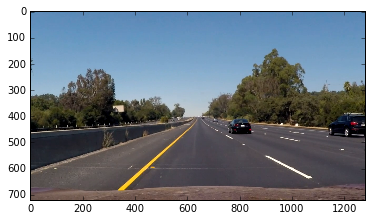

In [468]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

bboxes_list = []

video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!
video_output = "output_v2.mp4"
%time project_clip.write_videofile(video_output, audio=False)

print("Bounding boxes: ", bboxes_list)

In [469]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))